In this notebook, I extract the broadband flux time series as well as the spectrophometric time series (i.e. the raw transmission spectrum) from our HST data. 

In [1]:
# Importing modules we need:
import numpy as np
import matplotlib.pyplot as plt
import astropy
import astropy.convolution as ac
from astropy.io import fits
from scipy.interpolate import interp1d
# Importing HST extraction functions
#import HST_Extract_Funcs as hst
import HST_extraction as ext

I've placed the data in a separate directory off my home directory. Thomas' file structure that loads in the data, however, needs the data held in a directory that branches from the present working directory. Therefore, I'll need to edit this file structure to find where I've placed the data.

If the below block of code is commented out, then I've already done this so skip to next block to load in the new file path structure

In [2]:
# # Load in Thomas' file structure
# FSload = np.load('FilePaths.npz', allow_pickle=True)
# data_dict = FSload['filedict'].item()   # dictionary containing paths to the image files

# # Make a deep copy that I can edit
# import copy
# ddcopy = copy.deepcopy(data_dict)
# # Now to edit the paths within the copy dictionary
# for visit in data_dict:
#     # Go through each visit
#     for orbit in data_dict[visit]:
#         # Go through each orbit in that visit
#         #
#         # Each orbit has only one direct image
#         # First, edit this direct image's path
#         oldpath = data_dict[visit][orbit]['direct']
#         newpath = oldpath.replace('/home/matthew/data/hd219666b/hst_images/', '/home/mmmurphy/data/hd219666b/hst_images/')
#         ddcopy[visit][orbit]['direct'] = newpath
#         # Now looping through this orbit's grism images and editing their paths
#         grismpaths = data_dict[visit][orbit]['grism']
#         for i, oldpath in enumerate(grismpaths):
#             newpath = oldpath.replace('/home/matthew/data/hd219666b/hst_images/', '/home/mmmurphy/data/hd219666b/hst_images/')
#             ddcopy[visit][orbit]['grism'][i] = newpath
            
# # Saving this edited dictionary as the new file structure dictionary
# np.savez('FilePaths.npz', filedict=ddcopy)

Loading in the dictionary containing the file paths to our data

In [3]:
FPload = np.load('FilePaths.npz', allow_pickle=True)
datapaths = FPload['filedict'].item()   # dictionary containing paths to the image files

In [4]:
def apply_fixes(spectra, orbit, image):
    if orbit == 'orbit3':
        if image == 1:
            spectra[11, 13, 113] = np.median([spectra[11, 13, 112], spectra[11, 13, 114]])
            spectra[11, 14, 113] = np.median([spectra[11, 14, 112], spectra[11, 14, 115]])
            spectra[11, 14, 114] = np.median([spectra[11, 14, 113], spectra[11, 14, 115]])
        elif image == 4:
            spectra[7, 11, 86] = np.median([spectra[7,11,85], spectra[7,11,87]])
        elif image == 5:
            spectra[9,18,99] = np.median([spectra[9,18,98], spectra[9,18,100]])
        elif image == 13:
            spectra[10,12, 25:150] = np.median([spectra[10,11,25:150], spectra[10,11,25:150]], axis=0)
        elif image==14:
            spectra[8,11,157] = np.median([spectra[8,11,155], spectra[8,11,158]])
        elif image==15:
            spectra[10,11,107] = np.median([spectra[10,11,106], spectra[10,11,108]])
            spectra[10,12,107] = np.median([spectra[10,12,106], spectra[10,12,108]])
            
    return spectra

In [5]:
def binSpectrum(pixel_axis, spectrum, Nbins):
    
    bin_edges = np.linspace(pixel_axis[0], pixel_axis[-1], Nbins, endpoint=True)
    #print(bin_edges)
    bin_identities = np.digitize(pixel_axis, bin_edges) - 1
    #print(bin_identities)
    
    spectrum_binned = np.zeros(Nbins)
    i = 0
    while i <= (Nbins - 1):
        bin_member_idxs = np.where(bin_identities == i)[0]
        member_specvals = spectrum[bin_member_idxs]
        bin_specval = np.median(member_specvals)
        spectrum_binned[i] = bin_specval
        
        i += 1
    
    return bin_edges, spectrum_binned
    

In [6]:
def binspectrum(x_axis, spectrum, specerrors, Nbins):
    
    bin_edges = np.linspace(x_axis[0], x_axis[-1], Nbins+1, endpoint=True)
    #print(bin_edges)
    bin_identities = np.digitize(x_axis, bin_edges) - 1
    #print(bin_identities)
    
    spectrum_binned = np.zeros(Nbins)
    specerrs_binned = np.zeros(Nbins)
    bin_midxs = np.zeros(Nbins) 
    i = 0
    while i <= (Nbins - 1):
        bin_member_idxs = np.where(bin_identities == i)[0]
        member_specvals = spectrum[bin_member_idxs]
        member_errsvals = specerrors[bin_member_idxs]
        
        bin_specval = np.sum(member_specvals)
        bin_errsval = np.median(member_errsvals) / np.sqrt(len(member_errsvals))
        spectrum_binned[i] = bin_specval
        specerrs_binned[i] = bin_errsval
        
        try:
            # works until i = Nbins
            bin_midxs[i] = np.median([bin_edges[i], bin_edges[i+1]])
        except IndexError:
            lastbin_width = abs(x_axis[-1] - bin_edges[i])
            bin_midxs[i] = np.median([bin_edges[i], bin_edges[i]+lastbin_width])
        
        i += 1
    

    return bin_midxs, spectrum_binned, specerrs_binned

In [29]:
for orbit in datapaths['visit3']:
    # Going through each orbit in the visit
    #    reminder: we're only using visit 3's data
    if orbit != 'orbit2':
        #continue
        ...
    print('On orbit ', orbit)
    
    ######################################################
    # STEP 1a - Load in the direct image for this orbit
    #          and compute the wavelength solution
    direct_image_path = datapaths['visit3'][orbit]['direct']
    # compute the parameters of the wavelength solution:
    wavesolution = ext.WavelengthSolution(direct_image_path)    # contains parameters of the wavelength solution function
    # find the start & end values of the pixel range over which our spectrum is placed on the image
    min_wavelength = 9708   # Min wavelength of response function, [Angstrom]
    max_wavelength = 17904
    extractrange = ext.GetExtractRange(min_wavelength, max_wavelength, direct_image_path, 0)
    
    ## 1b - prepare the wavelength-pixel calibration
    full_dispaxis = np.arange(522.0)  # covers the dispersion axis, which is 522 pixels long
    waveFunc = wavesolution[0] + wavesolution[1]*(full_dispaxis - wavesolution[2])

    # waveInterp(wavelength in angstrom) returns the pixel value for that wavelength
    waveInterp = interp1d(waveFunc, full_dispaxis, kind='linear')
    
    ######################################################
    # STEP 2 - Go through each grism exposure in this orbit
    # Creating some arrays to contain the data of each grism exposure
    Nimages = len(datapaths['visit3'][orbit]['grism'])
    orbit_1Dspectra = [ [] for _ in range(Nimages)]        # 1D spectra of each image
    orbit_1Dspectra_uncs = [ [] for _ in range(Nimages)]   # 1D spectral errors of each image
    orbit_firstsubexp_1Dspectra = [ [] for _ in range(Nimages)] # 1D spectrum of each image's first sub-exp, for cross-correlation
    orbit_interpolatedfirstsubexp_1Dspectra = [ [] for _ in range(Nimages)] # 1D spectrum of each image's first sub-exp, for cross-correlation
    orbit_broadbands = np.zeros(Nimages)                   # Band-integrated flux of each image
    orbit_broadbands_uncs = np.zeros(Nimages)              # Band-integrated flux error of each image
    orbit_times = np.zeros(Nimages)
    orbit_spectral_xlimits = np.zeros((Nimages, 2))        # left and right-most x-values of extracted spectra to use for wavelength calibration
    orbit_backgrounds = np.zeros(Nimages)                  # keeps track of average background value for each image's sub-exposures
    orbit_scandirs = np.zeros(Nimages)                     # keeps track of each image's scan direction
    orbit_Nbadpixels = np.zeros(Nimages)                   # keeps track of the average number of bad pixels in each image's sub-exposures
    for image in range(Nimages):
        if image != 0:
            #continue
            ...
        print('Working on image ',image)
        
        ###################################################
        # STEP 3 - Separate out each sub-exposure within this image
        subexp_details = ext.CreateSubExps(datapaths['visit3'][orbit]['grism'][image], wavesolution)
        subexp_images = subexp_details[0]        # Array containing each sub-exposure's image array
        subexp_times = subexp_details[1]         # Array containing the time of each sub exposure [BJD TDB]
        subexp_badpixmasks = subexp_details[2]   # Array containing each sub-exposure's bad pixel mask
        subexp_dataqualities = subexp_details[3] # Array containing DQ flags on each sub-exposure
        subexp_scandirs = subexp_details[4]      # Array containing the scan direction of each sub-exposure
        subexp_shifts = subexp_details[6]        # Array containing angular shifting of each sub-exposure
        Nsubexps = subexp_images.shape[0]        # Number of sub-exposures in this image
        
        # tracking the time of each image, as the median of the time on each sub-exposure
        orbit_times[image] = np.median(subexp_times)
        # and the scan direction
        orbit_scandirs[image] = subexp_scandirs
        
        # doing a manual fix
        if orbit=='orbit4':
            if image==3:
                # some weird pixels that throw off the trace fitting if not zeroed out
                subexp_images[5, 150:200, 320:380] = 0.
        
        ###################################################
        # STEP 4 - Subtract out the background flux on each sub-exposure image
        bksub_details = ext.BkgdSub(subexp_images, subexp_badpixmasks, subexp_scandirs)
        bsub_subexp_images = bksub_details[0]  # each background subtracted sub-exposure image
        bsub_subexp_bkvals = bksub_details[1]  # background values of each sub-exposure
        bsub_subexp_bkerrs = bksub_details[2]  # uncertainty on above
        
        mean_subexp_bkval = np.mean(bsub_subexp_bkvals)
        orbit_backgrounds[image] = mean_subexp_bkval
        
        ###################################################
        # STEP 5 - Flat-field each background subtracted sub-exposure image
        # Path to the appropriate flat-field calibration image:
        flatimg = '/home/mmmurphy/data/hd219666b/calibrations/WFC3.IR.G141.flat.2.fits'
        flat_subexp_images = ext.FlatField(flatimg, bsub_subexp_images, wavesolution, subexp_shifts)
        
        
        ###################################################
        # STEP 6a - Extract the 2D target spectrum
        if (orbit=='orbit2') and (image==13):
            twoDspectra, boxCoords = ext.cutout2Dspectrum(flat_subexp_images, extractrange, 15, 5, returnCoords=True, manualOverride='o2i13')
        else:
            twoDspectra, boxCoords = ext.cutout2Dspectrum(flat_subexp_images, extractrange, 15, 5, returnCoords=True)
            
        # the left- and right-most pixel of our 2D cutout
        orbit_spectral_xlimits[image][0] = boxCoords[0][2] 
        orbit_spectral_xlimits[image][1] = boxCoords[0][3] # using just the first sub-exposure, since it's unshifted and we shift others to it
        
        ############## try and fix bad pixels ########################
        for subexp in range(twoDspectra.shape[0]):
            twoDspec = twoDspectra[subexp]
            nrows = twoDspec.shape[0]
            localmask = np.copy(subexp_badpixmasks[subexp])
            localmask = localmask[boxCoords[subexp][0]:boxCoords[subexp][1],
                                  boxCoords[subexp][2]:boxCoords[subexp][3]]
            for row in range(nrows):       
                if row == 0:
                    continue
                if row == nrows-1:
                    continue
                gauss_kernel = ac.Gaussian1DKernel(2)
                for k in range(1):
                    smoothed = ac.convolve(twoDspec[row, :], gauss_kernel)
                    resid = twoDspec[row, :] - smoothed
                    std = np.std(resid)
                    outlier = np.where(resid ** 2. > (4.0 * std) ** 2.)[0]
                    for point in outlier:
                        try:
                            #plt.scatter(point, row, facecolor='none', edgecolor='white')
                            twoDspec[row, point] = np.mean((twoDspec[row,point+2], twoDspec[row,point-2], twoDspec[row,point+1], twoDspec[row,point-1]))            
                        except IndexError:
                            #plt.scatter(point, row, facecolor='none', edgecolor='yellow')
                            twoDspec[row, point] = twoDspec[row, point-2]

                badpixs = np.where(localmask[row, :])
                for point in badpixs[0]:
                    try:
                        twoDspec[row, point] = (twoDspec[row, point+1] + twoDspec[row, point-1]) / 2.
                    except IndexError:
                        twoDspec[row, point] = twoDspec[row, point-1]            

        # compute average pixel value in the cutout
        print('average pixel values in the post-Guassian correction cut-out 2d spectrum:')
        for subexp in range(twoDspectra.shape[0]):
            twoDspec = twoDspectra[subexp]
            avg_pixel_value = np.mean(twoDspec)
            print('subexposure %d - value = %.1f'%(subexp, avg_pixel_value))
        
        # STEP 6b - Compute the wavelength - pixel calibration
        spec2Ddisppixels = np.arange(orbit_spectral_xlimits[image][0], orbit_spectral_xlimits[image][1], 1)
        temp_wavs = np.linspace(9000, 18000, 500)   # wide range that encompasses the WFC3/G141 wavelength range
        temp_pixs = waveInterp(temp_wavs)     # the corresponding pixels for the above
        # fit line with x = pixs and y = wavs; y = mx + b
        slope, intercept = np.polyfit(x=temp_pixs, y=temp_wavs, deg=1)
        # now apply this to our 2D cutout's pixels to get their corresponding wavelengths
        wavs = slope*spec2Ddisppixels + intercept        
        
        # STEP 6c - Extract the 2D data quality array
        DQspectra = np.zeros(twoDspectra.shape)
        for i in range(DQspectra.shape[0]):
            coords = boxCoords[i]
            DQspectra[i] = subexp_dataqualities[i, coords[0]:coords[1], coords[2]:coords[3]]

        ###################################################
        # Step 7 - Bad pixel correction
        #twoDspectra_corr, Nbadpixels_avg = ext.CorrectBadPixels(twoDspectra, DQspectra, Niter=5)
        #twoDspectra_corr = apply_fixes(twoDspectra_corr, orbit, image)
        
        twoDspectra_corr = np.copy(twoDspectra)
        Nbadpixels_avg = 9
        
        orbit_Nbadpixels[image] = Nbadpixels_avg
             
        ##################################################
        # STEP 8 - Fitting the spectral trace
        disp_axis, traces = ext.FitSpectralTrace(twoDspectra_corr)
        
        ##################################################
        # Step 9 - Extracting the 1D spectra
        oneDspectra, oneDerrors = ext.Extract1D(twoDspectra_corr, traces, extractionheight=14)
        orbit_firstsubexp_1Dspectra[image] = oneDspectra[0]
        
        # compute typical pixel value in the 1d spectra
        print('median pixel value & sum of the 1d spectra subexposures:')
        for subexp in range(oneDspectra.shape[0]):
            oneDspec = oneDspectra[subexp]
            med_pixel_value = np.median(oneDspec)
            sum_value = np.sum(oneDspec)
            print('subexposure %d - median = %.1f,  sum = %.1f * 10^7'%(subexp, med_pixel_value, (sum_value/1.e7)))
        
        #####################################################
        # STEP 10 - Cross-correlating the sub-exposure 1D spectra to correct for shifting
        min_shift = min(subexp_shifts[np.where(subexp_shifts > 0.)[0]]) # minimum shift determined from scan angles, will set the resolution of our interpolation
        x_uninterp = np.arange(len(oneDspectra[0]))
        x_interp = np.arange(x_uninterp[0], x_uninterp[-1], min_shift)
        interp_1Dspectra = np.zeros((oneDspectra.shape[0], len(x_interp)))
        for subexp in range(oneDspectra.shape[0]):
            # Create the interpolation function based on the observed, native resolution spectrum
            interp_1Dspectrum_subexp = interp1d(x=np.arange(len(oneDspectra[subexp])), y=oneDspectra[subexp], kind='quadratic')
            # interpolate to finer x_axis, based on minimum estimated shift
            subexp_interpolatedspectrum = interp_1Dspectrum_subexp(x_interp)
            # determine this subexposure's shift, in units of the new x-axis' spacing
            shiftsize = int(np.rint(subexp_shifts[subexp] / min_shift ))
            if (image+1)%2 == 0:
                shiftsize = -shiftsize 
                ...
            # shift this subexposure's interpoalted spectrum
            shifted_subexp_interpolatedspectrum = ext.shift(subexp_interpolatedspectrum, -shiftsize, yzerolevel=10000.) 
            # now resample the interpolated spectrum back to the native resolution
            resampled_shifted_subexpspectrum = binSpectrum(x_interp, shifted_subexp_interpolatedspectrum, len(oneDspectra[0]))[1]          
            # re-assigning the spectrum
            oneDspectra[subexp] = np.copy(resampled_shifted_subexpspectrum)
        
        orbit_firstsubexp_1Dspectra[image] = oneDspectra[0]
        ####################################################
        # STEP 11 - Combining the 1D spectra subexposures into the image 1D spectrum
        # we'll do this just by summing the shift-corrected spectra at each dispersion pixel
        # since they've been shifted already, the dispersion pixels should already line up
        # so sum axis = the N subexposure axis
        
        #grab_last_img = np.copy(oneDspectrum_img)
        oneDspectrum_img = np.sum(oneDspectra, axis=0)
        oneDerror_img = np.sqrt(np.sum(oneDspectra, axis=0))
        
        # compute typical pixel value in the 1d spectra
        print('median pixel value & sum of the full image 1d spectrum:')
        med_pixel_value = np.median(oneDspectrum_img)
        sum_value = np.sum(oneDspectrum_img)
        print('median = %.1f * 10^7,  sum = %.1f * 10^8'%((med_pixel_value/1.e7), (sum_value/1.e8)))
        
        
        #if image % 2 != 0:
        #    oneDspectrum_img = grab_last_img
        
        orbit_1Dspectra[image] = np.copy(oneDspectrum_img)
        orbit_1Dspectra_uncs[image] = np.copy(oneDerror_img)
        
        #######################################################
        # STEP 12 - Getting the image broadband flux value
        broadband_img = np.sum(oneDspectrum_img)
        broaderr_img = np.sqrt(np.sum(oneDspectrum_img))
        
        orbit_broadbands[image] = broadband_img                 # Band-integrated flux of each image
        orbit_broadbands_uncs[image] = broaderr_img
        
    orbit_1Dspectra = np.asarray(orbit_1Dspectra)
    orbit_1Dspectra_uncs = np.asarray(orbit_1Dspectra_uncs)
        
        
    ###
    ## step 12a - correct for the different dispersion between each scan direction
    ## here, we assume the even number images are of the "true" dispersion
    ##   and re-sample the odd number images at this dispersion
    ytrue = orbit_1Dspectra[0]  # image 0, true dispersion
    xtrue = np.arange(len(ytrue))
    
    # coefficients for a polynomial fit between pixel locations of equivalent features 
    #   in true vs. spread-out dispersions
    p3, p2, p1, p0 = -1.842685811717253e-06, 0.0006305528304224437, 0.9285915858960151, 1.2062373474205699
    xcorr = p3*(xtrue**3) + p2*(xtrue**2) + p1*xtrue + p0
    
    for img_number in range(orbit_1Dspectra.shape[0]):
        if img_number % 2 == 0:
            continue
        else:
            xinterp = np.zeros(len(xcorr)+2)
            yinterp = np.zeros(len(xcorr)+2)
            for xidx in range(len(xinterp)):
                if xidx == 0:
                    continue
                if xidx == len(xinterp)-1:
                    xinterp[xidx] = 180.
                    continue
                else:
                    xinterp[xidx] = xcorr[xidx-1]
                    yinterp[xidx] = orbit_1Dspectra[img_number][xidx-1]
                    
            interp_newdisp = interp1d(xinterp, yinterp, kind='quadratic')
            y_corr = interp_newdisp(xtrue)
            #orbit_1Dspectra[img_number] = y_corr
    
#     ######################
#     # STEP 12 - Cross-correlate the image 1D spectra in each orbit
#     min_shift2 = min_shift / 2.
#     x_uninterp = np.arange(len(orbit_firstsubexp_1Dspectra[0]))
#     x_interp = np.arange(x_uninterp[0], x_uninterp[-1], min_shift2)
#     orbit_firstsubexp_1Dspectra = np.asarray(orbit_firstsubexp_1Dspectra)
#     interp2_1Dspectra = np.zeros((orbit_firstsubexp_1Dspectra.shape[0], len(x_interp)))
#     for img in range(interp2_1Dspectra.shape[0]):
#         # Create the interpolation function based on the observed, native resolution spectrum
#         # need to do this both for the combined image spectrum, and that image's first sub-exposure spectrum
#         interp_1Dspectrum_imgsubexp = interp1d(x=np.arange(len(orbit_firstsubexp_1Dspectra[img])), y=orbit_firstsubexp_1Dspectra[img], kind='quadratic')
#         interp_1Dspectrum_imgfull = interp1d(x=np.arange(len(orbit_1Dspectra[img])), y=orbit_1Dspectra[img], kind='quadratic')
#         # interpolate to finer x_axis, based on minimum estimated shift
#         imgsubexp_interpolatedspectrum = interp_1Dspectrum_imgsubexp(x_interp)
#         orbit_interpolatedfirstsubexp_1Dspectra[img] = imgsubexp_interpolatedspectrum
#         imgfull_interpolatedspectrum = interp_1Dspectrum_imgfull(x_interp)
#         # determine this image's shift, in units of the new x-axis' spacing
#         x1 = np.arange(len(orbit_interpolatedfirstsubexp_1Dspectra[0]))
#         x2 = np.arange(len(orbit_interpolatedfirstsubexp_1Dspectra[img]))
#         plt.plot(x1, orbit_interpolatedfirstsubexp_1Dspectra[0])
#         plt.plot(x2, orbit_interpolatedfirstsubexp_1Dspectra[img])
#         plt.show()
#         shiftsize = ext.crosscorrelate(orbit_interpolatedfirstsubexp_1Dspectra[0], orbit_interpolatedfirstsubexp_1Dspectra[img], guesslimits=20, yzerolevel=20000.)[0]
#         if (img+1)%2 == 0:
#                 shiftsize = -shiftsize 
#                 #...
    
#         # now, we are shifting the combined image spectrum
#         # shift this subexposure's interpoalted spectrum
#         shifted_fullspectrum = ext.shift(imgfull_interpolatedspectrum, shiftsize-100, yzerolevel=20000.)
#         # now resample the interpolated spectrum back to the native resolution
#         resampled_shifted_fullspectrum = binSpectrum(x_interp, shifted_fullspectrum, len(x_uninterp))[1]          
#     #             plt.plot(x_uninterp, oneDspectra[subexp], c='black')
#     #             plt.plot(x_uninterp, resampled_shifted_subexpspectrum, c='orange')
#     #             plt.show()
#         # re-assigning the spectrum
#         orbit_1Dspectra[img] = np.copy(resampled_shifted_fullspectrum)

    ## single pixel shifting method
    image_1Dspecshifts = np.zeros(orbit_1Dspectra.shape[0], dtype=int)
    for i in range(orbit_1Dspectra.shape[0]):
        if i == 0:
            continue
#         if i % 2 != 0:
#             continue
        # we assume the first one is correct
        # finding the shift
        spec_shift = ext.crosscorrelate(orbit_1Dspectra[0], orbit_1Dspectra[i], guesslimits=5, yzerolevel=100000.)[0]
        image_1Dspecshifts[i] = spec_shift
        #image_1Dspecshifts[i] = -1.75

    # if there were shifts, here we correct them
    # we'll do this recursively until no shifts are detected
    shift_checks = np.copy(image_1Dspecshifts)
    while len(np.where(shift_checks != 0)[0]) != 0:
        toshift_idxs = np.where(image_1Dspecshifts != 0)[0]
        for idx in toshift_idxs:
            # un-shifting it
            orbit_1Dspectra[idx] = ext.shift(orbit_1Dspectra[idx], -image_1Dspecshifts[idx], 
                                          yzerolevel=500000.)
#             orbit_firstsubexp_1Dspectra[idx] = ext.shift(orbit_firstsubexp_1Dspectra[idx], -image_1Dspecshifts[idx], 
#                                           yzerolevel=50000.)
            # checking the new shift
            # if it's non-zero, this spectrum will go through the loop again
            shift_checks[idx] = ext.crosscorrelate(orbit_1Dspectra[0], orbit_1Dspectra[idx], guesslimits=5, yzerolevel=100000.)
    
        
    # Now to save things
    if orbit == 'orbit1':
        orbit1_1Dspectra = np.copy(orbit_1Dspectra)
        orbit1_1Dspectrauncs = np.copy(orbit_1Dspectra_uncs)
        orbit1_1Dspectra_firstsubexp = np.copy(orbit_firstsubexp_1Dspectra)
        orbit1_broadbands = np.copy(orbit_broadbands)
        orbit1_broadbands_uncs = np.copy(orbit_broadbands_uncs)
        orbit1_times = np.copy(orbit_times)
        orbit1_spectral_xlimits = np.copy(orbit_spectral_xlimits)
        orbit1_wavelengths = np.copy(wavs)
        orbit1_backgrounds = np.copy(orbit_backgrounds)
        orbit1_scandirs = np.copy(orbit_scandirs)
        orbit1_Nbadpixels = np.copy(orbit_Nbadpixels)
    elif orbit == 'orbit2':
        orbit2_1Dspectra = np.copy(orbit_1Dspectra)
        orbit2_1Dspectrauncs = np.copy(orbit_1Dspectra_uncs)
        orbit2_1Dspectra_firstsubexp = np.copy(orbit_firstsubexp_1Dspectra)
        orbit2_broadbands = np.copy(orbit_broadbands)
        orbit2_broadbands_uncs = np.copy(orbit_broadbands_uncs)
        orbit2_times = np.copy(orbit_times)
        orbit2_spectral_xlimits = np.copy(orbit_spectral_xlimits)
        orbit2_wavelengths = np.copy(wavs)
        orbit2_backgrounds = np.copy(orbit_backgrounds)
        orbit2_scandirs = np.copy(orbit_scandirs)
        orbit2_Nbadpixels = np.copy(orbit_Nbadpixels)
    elif orbit == 'orbit3':
        orbit3_1Dspectra = np.copy(orbit_1Dspectra)
        orbit3_1Dspectrauncs = np.copy(orbit_1Dspectra_uncs)
        orbit3_1Dspectra_firstsubexp = np.copy(orbit_firstsubexp_1Dspectra)
        orbit3_broadbands = np.copy(orbit_broadbands)
        orbit3_broadbands_uncs = np.copy(orbit_broadbands_uncs)
        orbit3_times = np.copy(orbit_times)
        orbit3_spectral_xlimits = np.copy(orbit_spectral_xlimits)
        orbit3_wavelengths = np.copy(wavs)
        orbit3_backgrounds = np.copy(orbit_backgrounds)
        orbit3_scandirs = np.copy(orbit_scandirs)
        orbit3_Nbadpixels = np.copy(orbit_Nbadpixels)
    elif orbit == 'orbit4':
        orbit4_1Dspectra = np.copy(orbit_1Dspectra)
        orbit4_1Dspectrauncs = np.copy(orbit_1Dspectra_uncs)
        orbit4_1Dspectra_firstsubexp = np.copy(orbit_firstsubexp_1Dspectra)
        orbit4_broadbands = np.copy(orbit_broadbands)
        orbit4_broadbands_uncs = np.copy(orbit_broadbands_uncs)
        orbit4_times = np.copy(orbit_times)
        orbit4_spectral_xlimits = np.copy(orbit_spectral_xlimits)
        orbit4_wavelengths = np.copy(wavs)
        orbit4_backgrounds = np.copy(orbit_backgrounds)
        orbit4_scandirs = np.copy(orbit_scandirs)
        orbit4_Nbadpixels = np.copy(orbit_Nbadpixels)

On orbit  orbit1
Working on image  0
average pixel values in the post-Guassian correction cut-out 2d spectrum:
subexposure 0 - value = 10318.3
subexposure 1 - value = 10307.6
subexposure 2 - value = 10305.2
subexposure 3 - value = 10315.0
subexposure 4 - value = 10310.2
subexposure 5 - value = 10321.5
subexposure 6 - value = 10315.6
subexposure 7 - value = 10317.7
subexposure 8 - value = 10315.2
subexposure 9 - value = 10316.1
subexposure 10 - value = 10298.7
subexposure 11 - value = 10247.0
subexposure 12 - value = 10283.3
subexposure 13 - value = 10371.3
median pixel value & sum of the 1d spectra subexposures:
subexposure 0 - median = 409539.0,  sum = 5.6 * 10^7
subexposure 1 - median = 410436.7,  sum = 5.6 * 10^7
subexposure 2 - median = 409967.5,  sum = 5.6 * 10^7
subexposure 3 - median = 410606.4,  sum = 5.6 * 10^7
subexposure 4 - median = 410682.4,  sum = 5.6 * 10^7
subexposure 5 - median = 412356.5,  sum = 5.6 * 10^7
subexposure 6 - median = 411733.7,  sum = 5.6 * 10^7
subexposu

/home/mmmurphy/inquiry/hd219666b/reduction/HST_extraction.py:353: RuntimeWarning: invalid value encountered in sqrt
  spec2D_photnoise = np.sqrt(spec2D)


average pixel values in the post-Guassian correction cut-out 2d spectrum:
subexposure 0 - value = 10287.4
subexposure 1 - value = 10403.3
subexposure 2 - value = 10369.4
subexposure 3 - value = 10431.3
subexposure 4 - value = 10455.0
subexposure 5 - value = 10455.0
subexposure 6 - value = 10458.8
subexposure 7 - value = 10451.0
subexposure 8 - value = 10461.8
subexposure 9 - value = 10438.6
subexposure 10 - value = 10451.1
subexposure 11 - value = 10446.7
subexposure 12 - value = 10441.1
subexposure 13 - value = 10468.9
median pixel value & sum of the 1d spectra subexposures:
subexposure 0 - median = 407112.9,  sum = 5.6 * 10^7
subexposure 1 - median = 415522.6,  sum = 5.6 * 10^7
subexposure 2 - median = 411712.0,  sum = 5.6 * 10^7
subexposure 3 - median = 415963.2,  sum = 5.6 * 10^7
subexposure 4 - median = 415515.9,  sum = 5.7 * 10^7
subexposure 5 - median = 417341.9,  sum = 5.7 * 10^7
subexposure 6 - median = 417881.9,  sum = 5.7 * 10^7
subexposure 7 - median = 417085.5,  sum = 5.7 

average pixel values in the post-Guassian correction cut-out 2d spectrum:
subexposure 0 - value = 10318.6
subexposure 1 - value = 10437.8
subexposure 2 - value = 10399.5
subexposure 3 - value = 10465.8
subexposure 4 - value = 10489.0
subexposure 5 - value = 10483.4
subexposure 6 - value = 10490.2
subexposure 7 - value = 10485.2
subexposure 8 - value = 10494.6
subexposure 9 - value = 10473.7
subexposure 10 - value = 10480.9
subexposure 11 - value = 10480.5
subexposure 12 - value = 10480.9
subexposure 13 - value = 10500.5
median pixel value & sum of the 1d spectra subexposures:
subexposure 0 - median = 409242.0,  sum = 5.6 * 10^7
subexposure 1 - median = 415144.4,  sum = 5.7 * 10^7
subexposure 2 - median = 413780.4,  sum = 5.6 * 10^7
subexposure 3 - median = 417059.2,  sum = 5.7 * 10^7
subexposure 4 - median = 417677.6,  sum = 5.7 * 10^7
subexposure 5 - median = 418373.9,  sum = 5.7 * 10^7
subexposure 6 - median = 418073.1,  sum = 5.7 * 10^7
subexposure 7 - median = 417864.1,  sum = 5.7 

average pixel values in the post-Guassian correction cut-out 2d spectrum:
subexposure 0 - value = 10324.2
subexposure 1 - value = 10443.6
subexposure 2 - value = 10408.9
subexposure 3 - value = 10471.9
subexposure 4 - value = 10495.4
subexposure 5 - value = 10491.4
subexposure 6 - value = 10499.4
subexposure 7 - value = 10491.0
subexposure 8 - value = 10501.0
subexposure 9 - value = 10480.4
subexposure 10 - value = 10487.7
subexposure 11 - value = 10489.2
subexposure 12 - value = 10489.4
subexposure 13 - value = 10511.5
median pixel value & sum of the 1d spectra subexposures:
subexposure 0 - median = 409223.0,  sum = 5.6 * 10^7
subexposure 1 - median = 415661.5,  sum = 5.7 * 10^7
subexposure 2 - median = 414396.8,  sum = 5.6 * 10^7
subexposure 3 - median = 417664.0,  sum = 5.7 * 10^7
subexposure 4 - median = 417097.3,  sum = 5.7 * 10^7
subexposure 5 - median = 418184.7,  sum = 5.7 * 10^7
subexposure 6 - median = 418875.7,  sum = 5.7 * 10^7
subexposure 7 - median = 419029.1,  sum = 5.7 

/home/mmmurphy/inquiry/hd219666b/reduction/HST_extraction.py:353: RuntimeWarning: invalid value encountered in sqrt
  spec2D_photnoise = np.sqrt(spec2D)


average pixel values in the post-Guassian correction cut-out 2d spectrum:
subexposure 0 - value = 10313.6
subexposure 1 - value = 10433.7
subexposure 2 - value = 10395.9
subexposure 3 - value = 10462.3
subexposure 4 - value = 10483.1
subexposure 5 - value = 10478.2
subexposure 6 - value = 10487.0
subexposure 7 - value = 10477.6
subexposure 8 - value = 10493.0
subexposure 9 - value = 10468.9
subexposure 10 - value = 10477.7
subexposure 11 - value = 10474.4
subexposure 12 - value = 10478.1
subexposure 13 - value = 10496.5
median pixel value & sum of the 1d spectra subexposures:
subexposure 0 - median = 408634.5,  sum = 5.6 * 10^7
subexposure 1 - median = 414809.4,  sum = 5.7 * 10^7
subexposure 2 - median = 413183.1,  sum = 5.6 * 10^7
subexposure 3 - median = 415518.6,  sum = 5.7 * 10^7
subexposure 4 - median = 416297.8,  sum = 5.7 * 10^7
subexposure 5 - median = 417286.9,  sum = 5.7 * 10^7
subexposure 6 - median = 419235.4,  sum = 5.7 * 10^7
subexposure 7 - median = 416183.3,  sum = 5.7 

average pixel values in the post-Guassian correction cut-out 2d spectrum:
subexposure 0 - value = 10323.0
subexposure 1 - value = 10444.8
subexposure 2 - value = 10405.3
subexposure 3 - value = 10471.5
subexposure 4 - value = 10489.7
subexposure 5 - value = 10488.2
subexposure 6 - value = 10493.5
subexposure 7 - value = 10488.0
subexposure 8 - value = 10500.8
subexposure 9 - value = 10481.4
subexposure 10 - value = 10487.6
subexposure 11 - value = 10485.4
subexposure 12 - value = 10488.4
subexposure 13 - value = 10506.2
median pixel value & sum of the 1d spectra subexposures:
subexposure 0 - median = 410400.1,  sum = 5.6 * 10^7
subexposure 1 - median = 414645.8,  sum = 5.7 * 10^7
subexposure 2 - median = 413942.4,  sum = 5.6 * 10^7
subexposure 3 - median = 416403.8,  sum = 5.7 * 10^7
subexposure 4 - median = 417941.7,  sum = 5.7 * 10^7
subexposure 5 - median = 418275.2,  sum = 5.7 * 10^7
subexposure 6 - median = 417899.9,  sum = 5.7 * 10^7
subexposure 7 - median = 418605.3,  sum = 5.7 

override engaged
override engaged
override engaged
override engaged
override engaged
override engaged
override engaged
override engaged
override engaged
override engaged
override engaged
override engaged
override engaged
override engaged
average pixel values in the post-Guassian correction cut-out 2d spectrum:
subexposure 0 - value = 10326.3
subexposure 1 - value = 10442.2
subexposure 2 - value = 10403.3
subexposure 3 - value = 10475.0
subexposure 4 - value = 10499.1
subexposure 5 - value = 10490.6
subexposure 6 - value = 10499.7
subexposure 7 - value = 10491.5
subexposure 8 - value = 10498.7
subexposure 9 - value = 10483.0
subexposure 10 - value = 10490.3
subexposure 11 - value = 10488.5
subexposure 12 - value = 10481.1
subexposure 13 - value = 10507.6
median pixel value & sum of the 1d spectra subexposures:
subexposure 0 - median = 409126.7,  sum = 5.6 * 10^7
subexposure 1 - median = 415657.1,  sum = 5.7 * 10^7
subexposure 2 - median = 413372.0,  sum = 5.6 * 10^7
subexposure 3 - medi

/home/mmmurphy/inquiry/hd219666b/reduction/HST_extraction.py:353: RuntimeWarning: invalid value encountered in sqrt
  spec2D_photnoise = np.sqrt(spec2D)


average pixel values in the post-Guassian correction cut-out 2d spectrum:
subexposure 0 - value = 10297.0
subexposure 1 - value = 10415.6
subexposure 2 - value = 10379.9
subexposure 3 - value = 10447.1
subexposure 4 - value = 10466.4
subexposure 5 - value = 10462.1
subexposure 6 - value = 10469.6
subexposure 7 - value = 10459.8
subexposure 8 - value = 10474.1
subexposure 9 - value = 10452.0
subexposure 10 - value = 10461.3
subexposure 11 - value = 10458.1
subexposure 12 - value = 10456.5
subexposure 13 - value = 10478.9
median pixel value & sum of the 1d spectra subexposures:
subexposure 0 - median = 407786.9,  sum = 5.6 * 10^7
subexposure 1 - median = 415152.7,  sum = 5.6 * 10^7
subexposure 2 - median = 412711.5,  sum = 5.6 * 10^7
subexposure 3 - median = 416401.7,  sum = 5.7 * 10^7
subexposure 4 - median = 415715.5,  sum = 5.7 * 10^7
subexposure 5 - median = 417360.2,  sum = 5.7 * 10^7
subexposure 6 - median = 417078.1,  sum = 5.7 * 10^7
subexposure 7 - median = 417753.5,  sum = 5.7 

average pixel values in the post-Guassian correction cut-out 2d spectrum:
subexposure 0 - value = 10306.1
subexposure 1 - value = 10424.9
subexposure 2 - value = 10387.2
subexposure 3 - value = 10456.3
subexposure 4 - value = 10476.1
subexposure 5 - value = 10469.9
subexposure 6 - value = 10481.0
subexposure 7 - value = 10467.6
subexposure 8 - value = 10477.2
subexposure 9 - value = 10463.1
subexposure 10 - value = 10470.6
subexposure 11 - value = 10467.1
subexposure 12 - value = 10470.5
subexposure 13 - value = 10487.0
median pixel value & sum of the 1d spectra subexposures:
subexposure 0 - median = 408009.8,  sum = 5.6 * 10^7
subexposure 1 - median = 413533.1,  sum = 5.6 * 10^7
subexposure 2 - median = 413657.3,  sum = 5.6 * 10^7
subexposure 3 - median = 416551.1,  sum = 5.7 * 10^7
subexposure 4 - median = 416675.8,  sum = 5.7 * 10^7
subexposure 5 - median = 417078.3,  sum = 5.7 * 10^7
subexposure 6 - median = 418622.6,  sum = 5.7 * 10^7
subexposure 7 - median = 417397.1,  sum = 5.7 

average pixel values in the post-Guassian correction cut-out 2d spectrum:
subexposure 0 - value = 10305.3
subexposure 1 - value = 10423.7
subexposure 2 - value = 10389.0
subexposure 3 - value = 10452.1
subexposure 4 - value = 10478.9
subexposure 5 - value = 10473.1
subexposure 6 - value = 10478.3
subexposure 7 - value = 10472.1
subexposure 8 - value = 10480.7
subexposure 9 - value = 10464.8
subexposure 10 - value = 10468.1
subexposure 11 - value = 10469.0
subexposure 12 - value = 10472.2
subexposure 13 - value = 10490.8
median pixel value & sum of the 1d spectra subexposures:
subexposure 0 - median = 408030.5,  sum = 5.6 * 10^7
subexposure 1 - median = 413718.5,  sum = 5.6 * 10^7
subexposure 2 - median = 412956.8,  sum = 5.6 * 10^7
subexposure 3 - median = 416428.9,  sum = 5.7 * 10^7
subexposure 4 - median = 415576.0,  sum = 5.7 * 10^7
subexposure 5 - median = 417701.3,  sum = 5.7 * 10^7
subexposure 6 - median = 418556.7,  sum = 5.7 * 10^7
subexposure 7 - median = 418052.0,  sum = 5.7 

/home/mmmurphy/inquiry/hd219666b/reduction/HST_extraction.py:353: RuntimeWarning: invalid value encountered in sqrt
  spec2D_photnoise = np.sqrt(spec2D)


average pixel values in the post-Guassian correction cut-out 2d spectrum:
subexposure 0 - value = 10308.6
subexposure 1 - value = 10431.2
subexposure 2 - value = 10396.9
subexposure 3 - value = 10458.7
subexposure 4 - value = 10480.7
subexposure 5 - value = 10479.0
subexposure 6 - value = 10483.3
subexposure 7 - value = 10476.0
subexposure 8 - value = 10490.3
subexposure 9 - value = 10467.1
subexposure 10 - value = 10470.6
subexposure 11 - value = 10476.0
subexposure 12 - value = 10475.4
subexposure 13 - value = 10493.5
median pixel value & sum of the 1d spectra subexposures:
subexposure 0 - median = 407972.7,  sum = 5.6 * 10^7
subexposure 1 - median = 414182.0,  sum = 5.7 * 10^7
subexposure 2 - median = 412557.0,  sum = 5.6 * 10^7
subexposure 3 - median = 416859.1,  sum = 5.7 * 10^7
subexposure 4 - median = 417343.7,  sum = 5.7 * 10^7
subexposure 5 - median = 418055.4,  sum = 5.7 * 10^7
subexposure 6 - median = 418744.3,  sum = 5.7 * 10^7
subexposure 7 - median = 417842.6,  sum = 5.7 

average pixel values in the post-Guassian correction cut-out 2d spectrum:
subexposure 0 - value = 10315.8
subexposure 1 - value = 10438.2
subexposure 2 - value = 10403.7
subexposure 3 - value = 10468.8
subexposure 4 - value = 10488.8
subexposure 5 - value = 10485.3
subexposure 6 - value = 10495.1
subexposure 7 - value = 10485.3
subexposure 8 - value = 10498.4
subexposure 9 - value = 10477.8
subexposure 10 - value = 10484.6
subexposure 11 - value = 10484.5
subexposure 12 - value = 10485.7
subexposure 13 - value = 10502.9
median pixel value & sum of the 1d spectra subexposures:
subexposure 0 - median = 409455.0,  sum = 5.6 * 10^7
subexposure 1 - median = 414710.1,  sum = 5.7 * 10^7
subexposure 2 - median = 414164.6,  sum = 5.6 * 10^7
subexposure 3 - median = 416978.5,  sum = 5.7 * 10^7
subexposure 4 - median = 417170.3,  sum = 5.7 * 10^7
subexposure 5 - median = 418509.3,  sum = 5.7 * 10^7
subexposure 6 - median = 419062.7,  sum = 5.7 * 10^7
subexposure 7 - median = 418228.7,  sum = 5.7 

average pixel values in the post-Guassian correction cut-out 2d spectrum:
subexposure 0 - value = 10320.0
subexposure 1 - value = 10441.9
subexposure 2 - value = 10404.1
subexposure 3 - value = 10470.7
subexposure 4 - value = 10494.0
subexposure 5 - value = 10489.9
subexposure 6 - value = 10495.4
subexposure 7 - value = 10484.7
subexposure 8 - value = 10496.6
subexposure 9 - value = 10480.6
subexposure 10 - value = 10485.5
subexposure 11 - value = 10486.9
subexposure 12 - value = 10490.0
subexposure 13 - value = 10507.2
median pixel value & sum of the 1d spectra subexposures:
subexposure 0 - median = 409040.2,  sum = 5.6 * 10^7
subexposure 1 - median = 415698.5,  sum = 5.7 * 10^7
subexposure 2 - median = 414411.1,  sum = 5.6 * 10^7
subexposure 3 - median = 415735.1,  sum = 5.7 * 10^7
subexposure 4 - median = 416956.8,  sum = 5.7 * 10^7
subexposure 5 - median = 418266.6,  sum = 5.7 * 10^7
subexposure 6 - median = 419125.4,  sum = 5.7 * 10^7
subexposure 7 - median = 418240.1,  sum = 5.7 

In [8]:
print('Typical background flux levels [e/s]')
print('orbit 1: %.1f +/- %.1f'%(np.mean(orbit1_backgrounds), np.std(orbit1_backgrounds)))
print('orbit 2: %.1f +/- %.1f'%(np.mean(orbit2_backgrounds), np.std(orbit2_backgrounds)))
print('orbit 3: %.1f +/- %.1f'%(np.mean(orbit3_backgrounds), np.std(orbit3_backgrounds)))
print('orbit 4: %.1f +/- %.1f'%(np.mean(orbit4_backgrounds), np.std(orbit4_backgrounds)))
print('Average and maximum number of bad pixels per image')
print('orbit 1: %.1f, %.d'%(np.mean(orbit1_Nbadpixels), np.max(orbit1_Nbadpixels)))
print('orbit 2: %.1f, %.d'%(np.mean(orbit2_Nbadpixels), np.max(orbit2_Nbadpixels)))
print('orbit 3: %.1f, %.d'%(np.mean(orbit3_Nbadpixels), np.max(orbit3_Nbadpixels)))
print('orbit 4: %.1f, %.d'%(np.mean(orbit4_Nbadpixels), np.max(orbit4_Nbadpixels)))

Typical background flux levels [e/s]
orbit 1: 11.0 +/- 0.6
orbit 2: 11.0 +/- 0.6
orbit 3: 11.0 +/- 0.7
orbit 4: 10.7 +/- 0.5
Average and maximum number of bad pixels per image
orbit 1: 9.0, 9
orbit 2: 9.0, 9
orbit 3: 9.0, 9
orbit 4: 9.0, 9


Pulling out the broadband light curves and preparing them for fitting by normalizing and saving the data. 

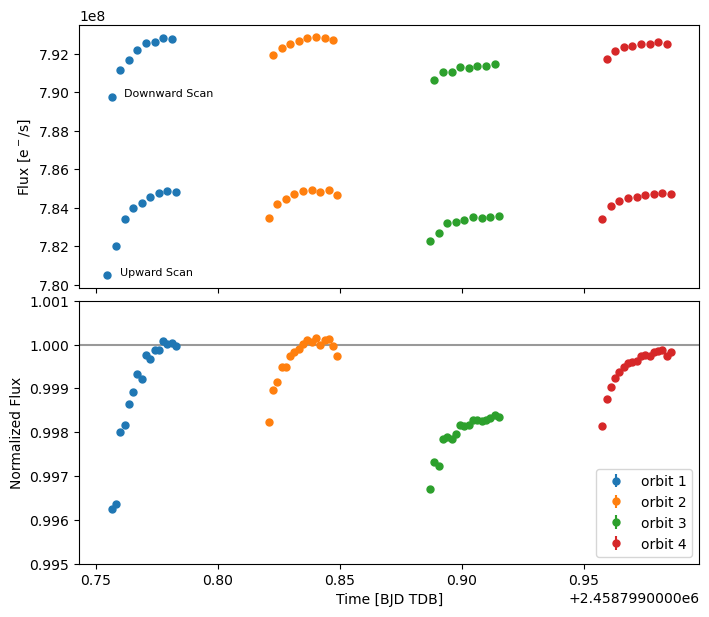

In [9]:
## Normalizing the broadband data
# I'll normalize by the median of the maxes of the out-of-transit orbits
# This way, the HST hook reaches a max of ~1 for both
y1 = orbit1_broadbands
y2 = orbit2_broadbands
y3 = orbit3_broadbands
y4 = orbit4_broadbands
e1 = orbit1_broadbands_uncs
e2 = orbit2_broadbands_uncs
e3 = orbit3_broadbands_uncs
e4 = orbit4_broadbands_uncs
t1 = orbit1_times
t2 = orbit2_times
t3 = orbit3_times
t4 = orbit4_times

normval1 = np.median([np.max(orbit2_broadbands[::2]), np.max(orbit4_broadbands[::2])])
normval2 = np.median([np.max(orbit2_broadbands[1::2]), np.max(orbit4_broadbands[1::2])])

no1 = np.copy(orbit1_broadbands)
eo1 = np.copy(orbit1_broadbands_uncs)
no1[::2] /= normval1
eo1[::2] /= normval1
no1[1::2] /= normval2
eo1[1::2] /= normval2
no2 = np.copy(orbit2_broadbands)
eo2 = np.copy(orbit2_broadbands_uncs)
no2[::2] /= normval1
eo2[::2] /= normval1
no2[1::2] /= normval2
eo2[1::2] /= normval2
no3 = np.copy(orbit3_broadbands)
eo3 = np.copy(orbit3_broadbands_uncs)
no3[::2] /= normval1
eo3[::2] /= normval1
no3[1::2] /= normval2
eo3[1::2] /= normval2
no4 = np.copy(orbit4_broadbands)
eo4 = np.copy(orbit4_broadbands_uncs)
no4[::2] /= normval1
eo4[::2] /= normval1
no4[1::2] /= normval2
eo4[1::2] /= normval2

# Looking at the normalized broadband light curve
#    with each orbit labeled
fig, ax = plt.subplots(figsize=(8,7), nrows=2, sharex=True)
plt.subplots_adjust(hspace=0.05)
# un-normalized
ax[0].errorbar(t1, orbit1_broadbands, yerr=orbit1_broadbands_uncs, ls='None', marker='o', ms=5, label='orbit 1')
ax[0].errorbar(t2, orbit2_broadbands, yerr=orbit2_broadbands_uncs, ls='None', marker='o', ms=5, label='orbit 2')
ax[0].errorbar(t3, orbit3_broadbands, yerr=orbit3_broadbands_uncs, ls='None', marker='o', ms=5, label='orbit 3')
ax[0].errorbar(t4, orbit4_broadbands, yerr=orbit4_broadbands_uncs, ls='None', marker='o', ms=5, label='orbit 4')
ax[0].text(t1[0]+0.005, orbit1_broadbands[0], 'Upward Scan', fontsize=8)
ax[0].text(t1[1]+0.005, orbit1_broadbands[1], 'Downward Scan', fontsize=8)
ax[0].set_ylabel(r'Flux [e$^-$/s]')
# normalized
ax[1].errorbar(t1, no1, yerr=eo1, ls='None', marker='o', ms=5, label='orbit 1')
ax[1].errorbar(t2, no2, yerr=eo2, ls='None', marker='o', ms=5, label='orbit 2')
ax[1].errorbar(t3, no3, yerr=eo3, ls='None', marker='o', ms=5, label='orbit 3')
ax[1].errorbar(t4, no4, yerr=eo4, ls='None', marker='o', ms=5, label='orbit 4')
ax[1].axhline(1., c='black', alpha=0.4)
ax[1].set_ylim((0.995, 1.001))
ax[1].set_xlabel('Time [BJD TDB]')
ax[1].set_ylabel('Normalized Flux')
ax[1].legend(loc='lower right')
plt.savefig('figures/broadband_lightcurve.png', dpi=400, bbox_inches='tight')
plt.show()

In [10]:
upscan_idxs = np.where(orbit2_scandirs == 0.)[0]
downscan_idxs = np.where(orbit2_scandirs == 1.)[0]

print('For orbit 2:')
print('Mean flux of upward scan images = %.2f * 10^8'%(np.mean(orbit2_broadbands[upscan_idxs])/1.e8))
print('Mean flux of downward scan images = %.2f * 10^8'%(np.mean(orbit2_broadbands[downscan_idxs])/1.e8))
offsets = []
for i, val in enumerate(orbit2_broadbands):
    if i == 0:
        continue
    diff = orbit2_broadbands[i] - orbit2_broadbands[i-1]
    offsets.append(diff)
offsets = np.asarray(offsets)
print('Typical offset due to scandir = %.0f'%(np.mean(offsets)))

For orbit 2:
Mean flux of upward scan images = 7.93 * 10^8
Mean flux of downward scan images = 7.85 * 10^8
Typical offset due to scandir = 73975


In [11]:
savebbData = False
if savebbData:
    datapath = '/home/mmmurphy/data/hd219666b/reduced_data/'
    np.savez(datapath+'orbit1_extractednormalizedbroadbanddata.npz', times=orbit1_times, broadbandflux=no1, broadbanderrs=eo1)
    np.savez(datapath+'orbit2_extractednormalizedbroadbanddata.npz', times=orbit2_times, broadbandflux=no2, broadbanderrs=eo2)
    np.savez(datapath+'orbit3_extractednormalizedbroadbanddata.npz', times=orbit3_times, broadbandflux=no3, broadbanderrs=eo3)
    np.savez(datapath+'orbit4_extractednormalizedbroadbanddata.npz', times=orbit4_times, broadbandflux=no4, broadbanderrs=eo4)
    print('Data Saved to directory: ', datapath)

Now pulling out the 1D spectra and preparing the spectral light curves

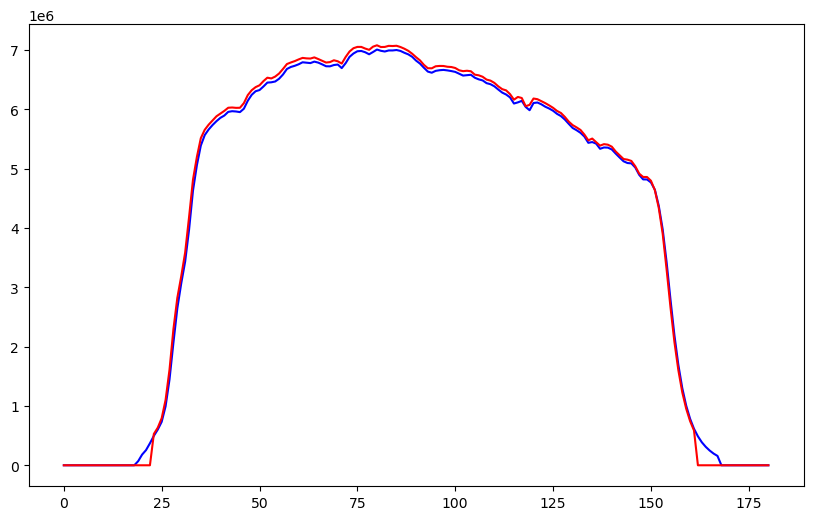

In [12]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(orbit3_1Dspectra[2])), orbit3_1Dspectra[2], c='blue')
plt.plot(np.arange(len(orbit3_1Dspectra[3])), orbit3_1Dspectra[3], c='red')
plt.show()

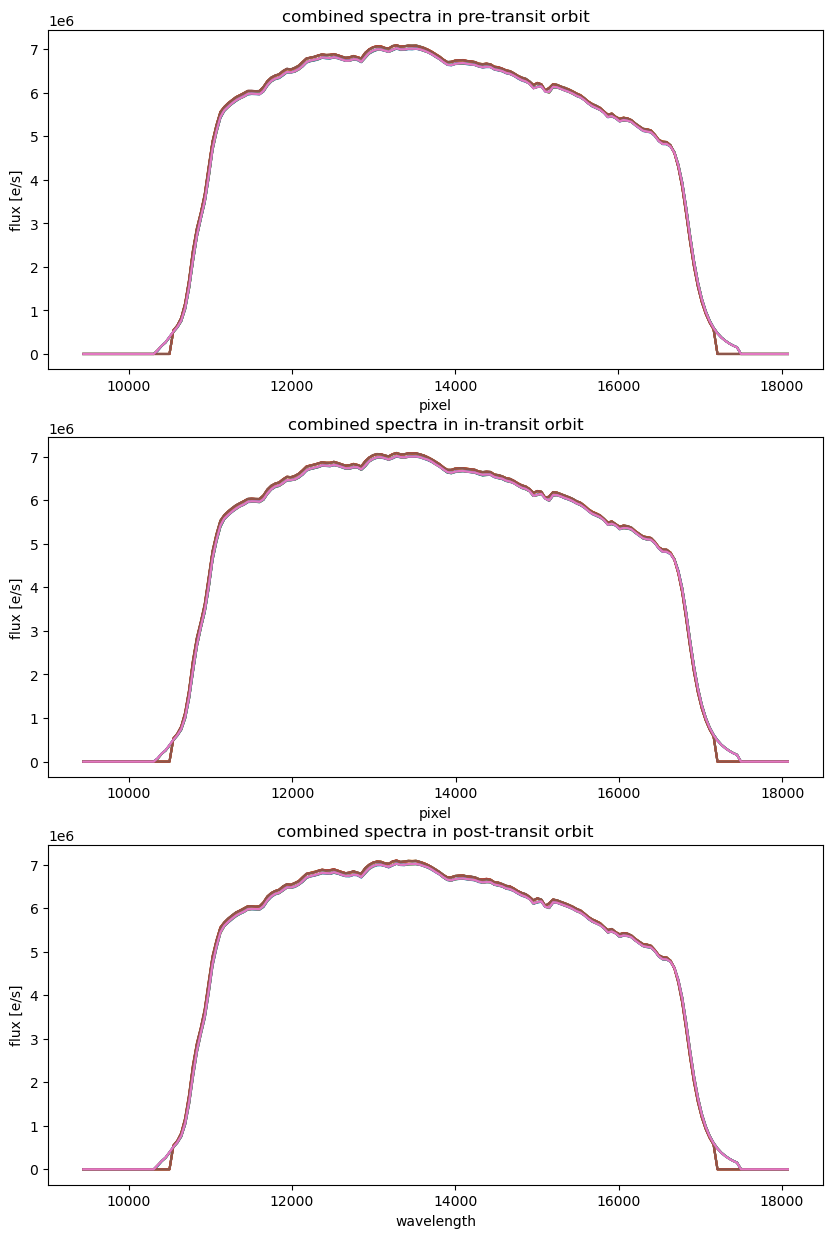

In [13]:
fig, ax = plt.subplots(figsize=(10,15), nrows=3)
ax[0].set_title('combined spectra in pre-transit orbit')
ax[1].set_title('combined spectra in in-transit orbit')
ax[2].set_title('combined spectra in post-transit orbit')
for img in range(orbit2_1Dspectra.shape[0]):
    y = orbit2_1Dspectra[img]
    #x = np.arange(len(y))
    x = orbit2_wavelengths
    ax[0].plot(x,y, label=img)
ax[0].set_xlabel('pixel')
ax[0].set_ylabel('flux [e/s]')
for img in range(orbit3_1Dspectra.shape[0]):
    y = orbit3_1Dspectra[img]
    #x = np.arange(len(y))
    x = orbit3_wavelengths
    ax[1].plot(x,y, label=img)
ax[1].set_xlabel('pixel')
ax[1].set_ylabel('flux [e/s]')
for img in range(orbit4_1Dspectra.shape[0]):
    y = orbit4_1Dspectra[img]
    #x = np.arange(len(y))
    x = orbit4_wavelengths
    ax[2].plot(x,y, label=img)
ax[2].set_xlabel('wavelength')
ax[2].set_ylabel('flux [e/s]')
#plt.legend(loc='best', ncol=3)
plt.show()

In [19]:
spec_o1, errs_o1 = np.copy(orbit1_1Dspectra), np.copy(orbit1_1Dspectrauncs)
spec_o2, errs_o2 = np.copy(orbit2_1Dspectra), np.copy(orbit2_1Dspectrauncs)
spec_o3, errs_o3 = np.copy(orbit3_1Dspectra), np.copy(orbit3_1Dspectrauncs)
spec_o4, errs_o4 = np.copy(orbit4_1Dspectra), np.copy(orbit4_1Dspectrauncs)

# Defining the number of bins to use
Nbins = 15
# We extracted more wavelengths than are to be used, as the edges go over the filter's response
#   so we need to slightly trim our spectra
G141_minwav = 11250.
G141_maxwav = 16500.
o1_goodwav_idxs = np.where((orbit1_wavelengths >= G141_minwav) & (orbit1_wavelengths <= G141_maxwav))[0]
o2_goodwav_idxs = np.where((orbit2_wavelengths >= G141_minwav) & (orbit2_wavelengths <= G141_maxwav))[0]
o3_goodwav_idxs = np.where((orbit3_wavelengths >= G141_minwav) & (orbit3_wavelengths <= G141_maxwav))[0]
o4_goodwav_idxs = np.where((orbit4_wavelengths >= G141_minwav) & (orbit4_wavelengths <= G141_maxwav))[0]

gwaves_o1 = orbit1_wavelengths[o1_goodwav_idxs]
gwaves_o2 = orbit2_wavelengths[o2_goodwav_idxs]
gwaves_o3 = orbit3_wavelengths[o3_goodwav_idxs]
gwaves_o4 = orbit4_wavelengths[o4_goodwav_idxs]

trimmed_spec_o1, trimmed_errs_o1 = np.zeros((spec_o1.shape[0], len(gwaves_o1))), np.zeros((spec_o1.shape[0], len(gwaves_o1)))
trimmed_spec_o2, trimmed_errs_o2 = np.zeros((spec_o2.shape[0], len(gwaves_o2))), np.zeros((spec_o2.shape[0], len(gwaves_o2)))
trimmed_spec_o3, trimmed_errs_o3 = np.zeros((spec_o3.shape[0], len(gwaves_o3))), np.zeros((spec_o3.shape[0], len(gwaves_o3)))
trimmed_spec_o4, trimmed_errs_o4 = np.zeros((spec_o4.shape[0], len(gwaves_o4))), np.zeros((spec_o4.shape[0], len(gwaves_o4)))

for img in range(spec_o1.shape[0]):
    # luckily, each orbit has the same number of images so i only need to do one loop
    trimmed_spec_o1[img], trimmed_errs_o1[img] = spec_o1[img][o1_goodwav_idxs], errs_o1[img][o1_goodwav_idxs]
    trimmed_spec_o2[img], trimmed_errs_o2[img] = spec_o2[img][o2_goodwav_idxs], errs_o2[img][o2_goodwav_idxs]
    trimmed_spec_o3[img], trimmed_errs_o3[img] = spec_o3[img][o3_goodwav_idxs], errs_o3[img][o3_goodwav_idxs]
    trimmed_spec_o4[img], trimmed_errs_o4[img] = spec_o4[img][o4_goodwav_idxs], errs_o4[img][o4_goodwav_idxs]
    
Nimages = spec_o1.shape[0]
binnedspec_o1, binnederrs_o1 = np.zeros((Nimages, Nbins)), np.zeros((Nimages, Nbins))
binnedspec_o2, binnederrs_o2 = np.zeros((Nimages, Nbins)), np.zeros((Nimages, Nbins))
binnedspec_o3, binnederrs_o3 = np.zeros((Nimages, Nbins)), np.zeros((Nimages, Nbins))
binnedspec_o4, binnederrs_o4 = np.zeros((Nimages, Nbins)), np.zeros((Nimages, Nbins))
for img in range(Nimages):
    binnedwavs_o1, binnedspec_o1[img], binnederrs_o1[img] = binspectrum(gwaves_o1, trimmed_spec_o1[img], trimmed_errs_o1[img], Nbins)
    binnedwavs_o2, binnedspec_o2[img], binnederrs_o2[img] = binspectrum(gwaves_o2, trimmed_spec_o2[img], trimmed_errs_o2[img], Nbins)
    binnedwavs_o3, binnedspec_o3[img], binnederrs_o3[img] = binspectrum(gwaves_o3, trimmed_spec_o3[img], trimmed_errs_o3[img], Nbins)
    binnedwavs_o4, binnedspec_o4[img], binnederrs_o4[img] = binspectrum(gwaves_o4, trimmed_spec_o4[img], trimmed_errs_o4[img], Nbins)
    
normspec_o2, normerrs_o2 = np.copy(binnedspec_o2), np.copy(binnederrs_o2)
normspec_o3, normerrs_o3 = np.copy(binnedspec_o3), np.copy(binnederrs_o3)
normspec_o4, normerrs_o4 = np.copy(binnedspec_o4), np.copy(binnederrs_o4)
fulltimes = np.concatenate((orbit2_times, orbit3_times, orbit4_times))
fullspec = np.concatenate((binnedspec_o2, binnedspec_o3, binnedspec_o4), axis=0)
fullnormspec = np.copy(fullspec)
fullnormerrs = np.concatenate((binnederrs_o2, binnederrs_o3, binnederrs_o4), axis=0)
fullscandirs = np.concatenate((orbit2_scandirs, orbit3_scandirs, orbit4_scandirs))
sd1_idxs = np.where(fullscandirs == 1.)[0]
sd0_idxs = np.where(fullscandirs == 0.)[0]

for wav in range(Nbins):
    normval1 = np.median(fullspec[:,wav][sd1_idxs]) #np.max(binnedspec_o2[:,wav][::2])
    normval0 = np.median(fullspec[:,wav][sd0_idxs]) #np.max(binnedspec_o2[:,wav][1::2])
    
    fullnormspec[:,wav][sd1_idxs] /= normval1
    fullnormspec[:,wav][sd0_idxs] /= normval0
    fullnormerrs[:,wav][sd1_idxs] /= normval1
    fullnormerrs[:,wav][sd0_idxs] /= normval0
    
#     normspec_o2[:,wav][sd1_idxs] /= normval1
#     normspec_o2[:,wav][sd0_idxs] /= normval0
#     normerrs_o2[:,wav][sd1_idxs] /= normval1
#     normerrs_o2[:,wav][sd0_idxs] /= normval0
    
#     normspec_o3[:,wav][sd1_idxs] /= normval1
#     normspec_o3[:,wav][sd0_idxs] /= normval0
#     normerrs_o3[:,wav][sd1_idxs] /= normval1
#     normerrs_o3[:,wav][sd0_idxs] /= normval0    
    
#     normspec_o4[:,wav][sd1_idxs] /= normval1
#     normspec_o4[:,wav][sd0_idxs] /= normval0
#     normerrs_o4[:,wav][sd1_idxs] /= normval1
#     normerrs_o4[:,wav][sd0_idxs] /= normval0    
    
    
saveRaw = False
if saveRaw:
    datapath = '/home/mmmurphy/data/hd219666b/reduced_data/'
    np.savez(datapath+'allorbits_rawSpectralLightcurves.npz',
            orbit2_times=orbit2_times, orbit2_flux=binnedspec_o2, orbit2_error=binnederrs_o2, orbit2_scandirs=orbit2_scandirs,
            orbit3_times=orbit3_times, orbit3_flux=binnedspec_o3, orbit3_error=binnederrs_o3, orbit3_scandirs=orbit3_scandirs,
            orbit4_times=orbit4_times, orbit4_flux=binnedspec_o4, orbit4_error=binnederrs_o4, orbit4_scandirs=orbit4_scandirs)
    print('Data Saved to directory: ', datapath)

In [20]:
loadTs = True
if loadTs:
    # load in thomas'
    tsdata = np.load('../test/Transit_Spectra_NoFirst_Visit3.npz')
    timesT = tsdata['time']
    t_visit = timesT - timesT[0]
    rawfluxes = tsdata['flux']
    rawerrors = tsdata['error']
    scandirs = tsdata['scandir']
    #waves = tsdata['wavelengths']

    fluxesT = np.copy(rawfluxes)
    errorsT = np.copy(rawerrors)
    Nbins = rawfluxes.shape[0]
    for wav in range(Nbins):
        # normalizing thomas'
        sd1_idxs = np.where(scandirs == 1.)[0]
        sd0_idxs = np.where(scandirs == 0.)[0]

        # if normalizing by max flux in second orbit:
    #     orbit2_sd1 = rawfluxes[wav,:][sd1_idxs][:8]
    #     orbit2_sd0 = rawfluxes[wav,:][sd0_idxs][:8]
    #     normval1, normval0 = np.max(orbit2_sd1), np.max(orbit2_sd0)
        # if normalizing by median flux of whole visit
        normval1 = np.median(fluxesT[wav, sd1_idxs])
        normval0 = np.median(fluxesT[wav, sd0_idxs])

        fluxesT[wav, sd1_idxs] /= normval1
        errorsT[wav, sd1_idxs] /= normval1
        fluxesT[wav, sd0_idxs] /= normval0
        errorsT[wav, sd0_idxs] /= normval0

average difference = 4.4 * 10^6


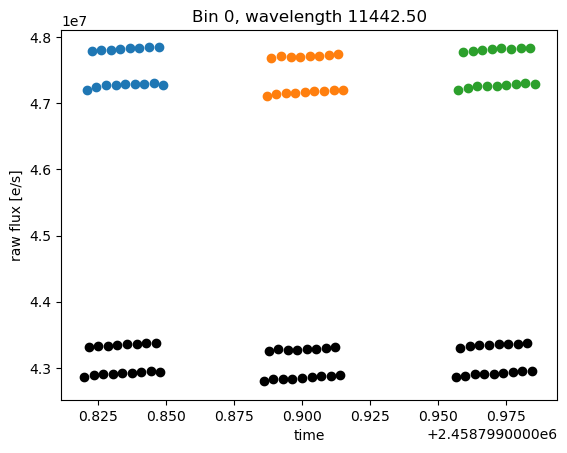

average difference = 1.2 * 10^6


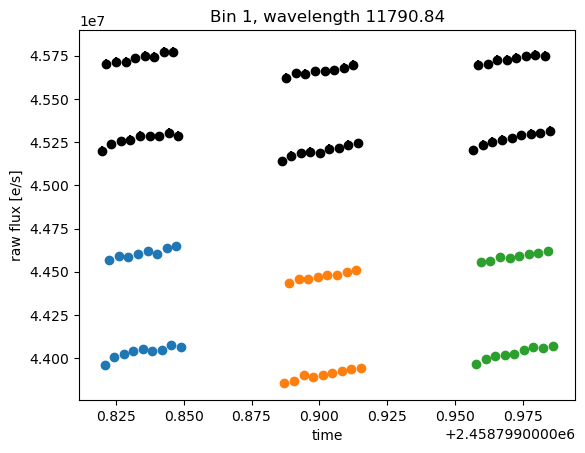

average difference = 1.8 * 10^6


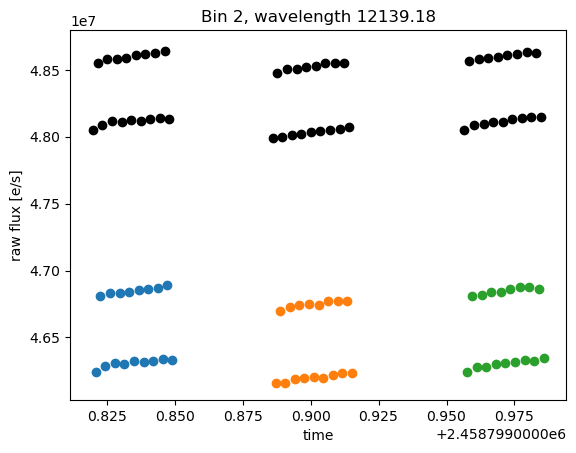

average difference = 4.4 * 10^6


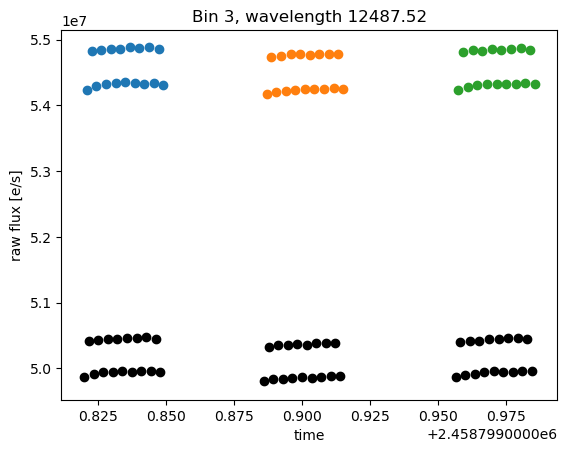

average difference = 2.0 * 10^6


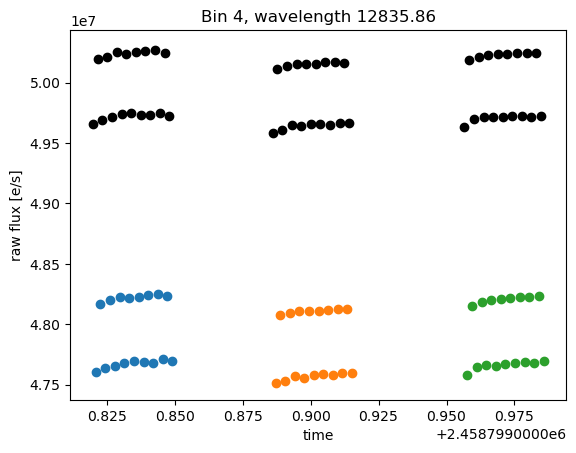

average difference = 2.3 * 10^6


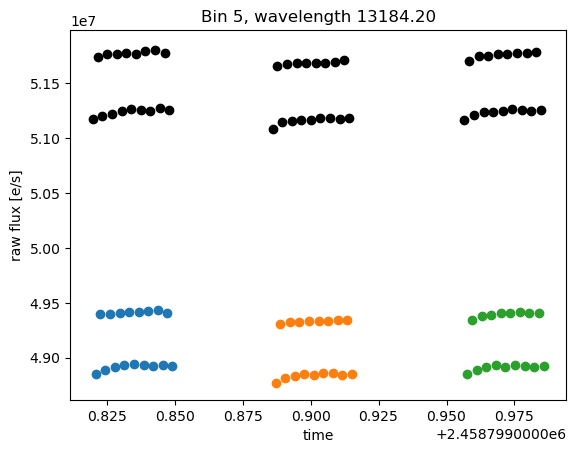

average difference = 2.6 * 10^6


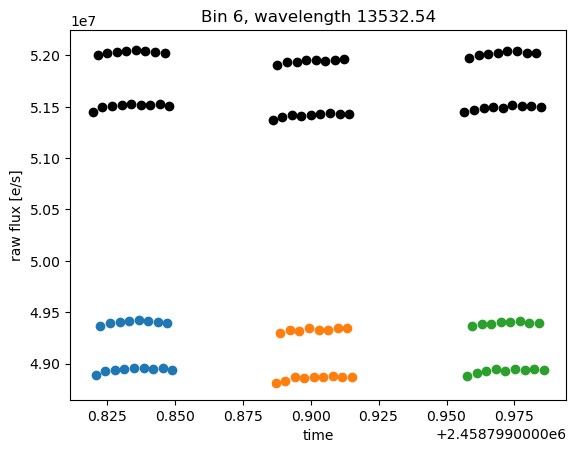

average difference = 3.9 * 10^6


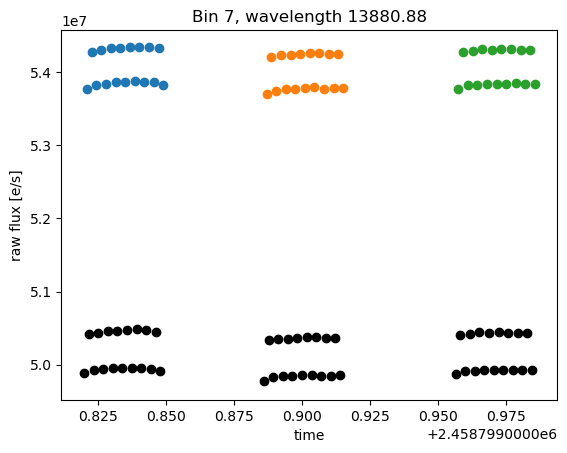

average difference = 2.5 * 10^6


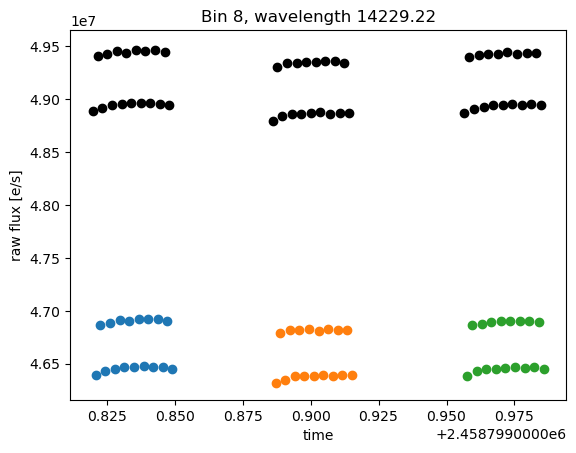

average difference = 2.6 * 10^6


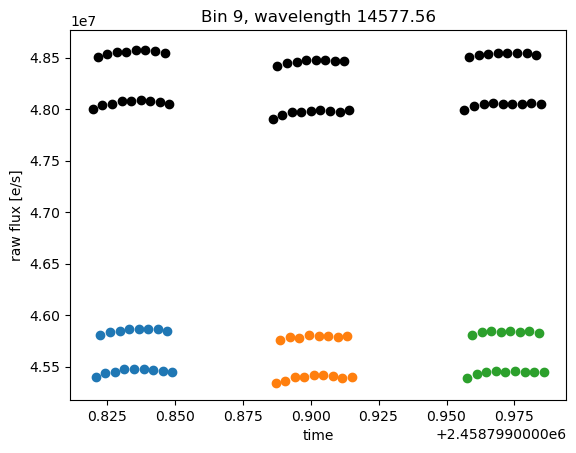

average difference = 2.7 * 10^6


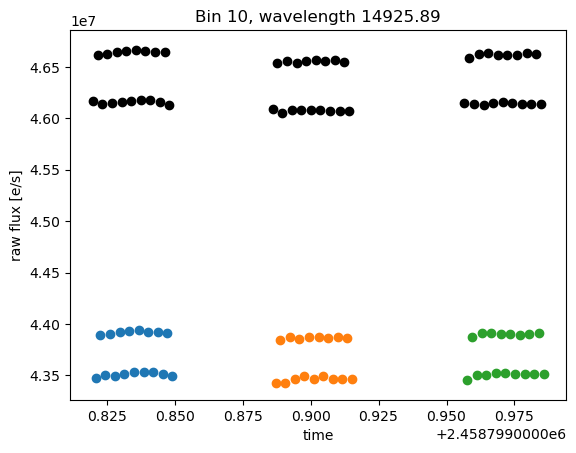

average difference = 3.7 * 10^6


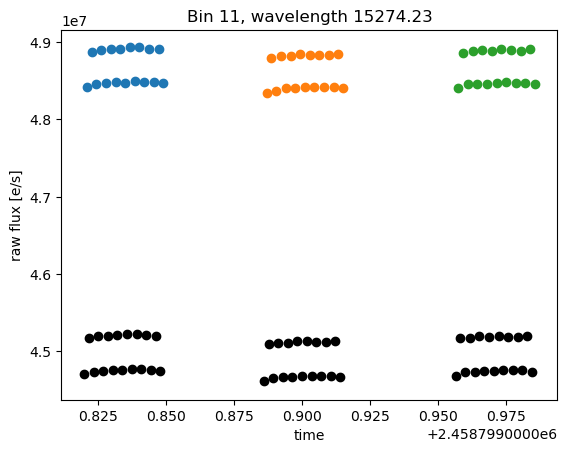

average difference = 2.8 * 10^6


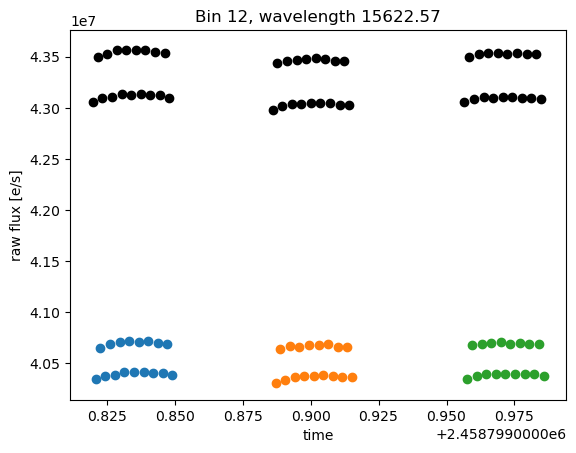

average difference = 2.3 * 10^6


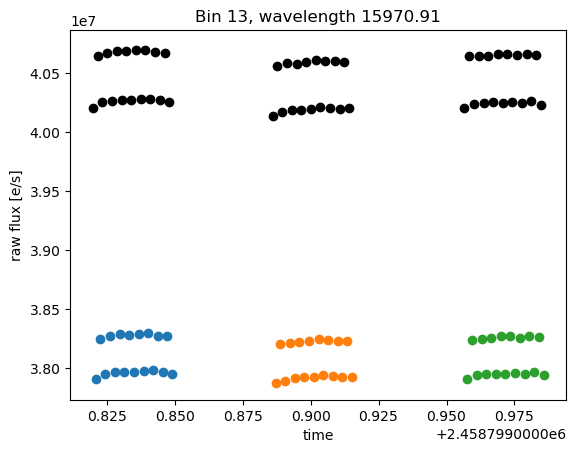

average difference = 2.3 * 10^6


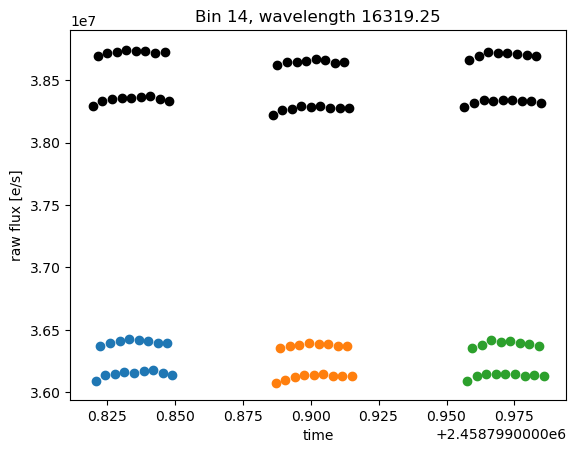

In [31]:
for i in range(binnedspec_o2.shape[1]):
    plt.title('Bin %d, wavelength %.2f'%(i, binnedwavs_o2[i]))
    if loadTs:
        plt.errorbar(timesT, rawfluxes[i,:], rawerrors[i,:], c='black', ls='None', marker='o')
    plt.errorbar(orbit2_times, binnedspec_o2[:,i], binnederrs_o2[:,i], ls='None', marker='o')
    plt.errorbar(orbit3_times, binnedspec_o3[:,i], binnederrs_o3[:,i], ls='None', marker='o')
    plt.errorbar(orbit4_times, binnedspec_o4[:,i], binnederrs_o4[:,i], ls='None', marker='o')
    plt.xlabel('time')
    plt.ylabel('raw flux [e/s]')
    
    differences = np.zeros(fullspec.shape[1])
    for j in range(fullspec.shape[1]):
        differences[j] = abs(fullspec[j,i] - rawfluxes[i,j])
    avg_difference = np.mean(differences)
    print('average difference = %.1f * 10^6'%(avg_difference/1.e6))
    
    plt.show()

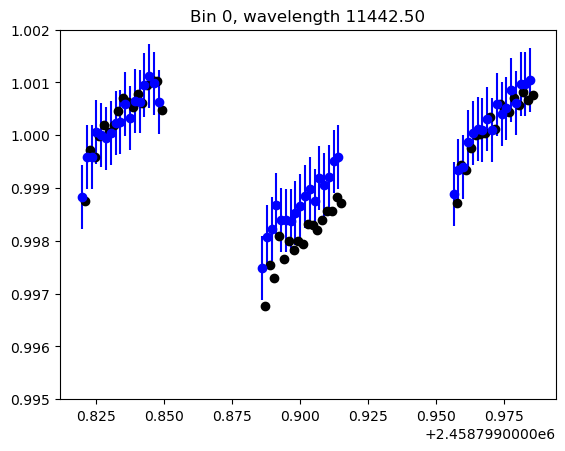

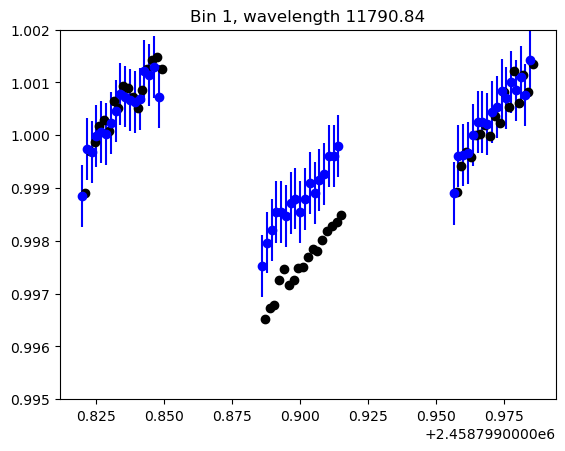

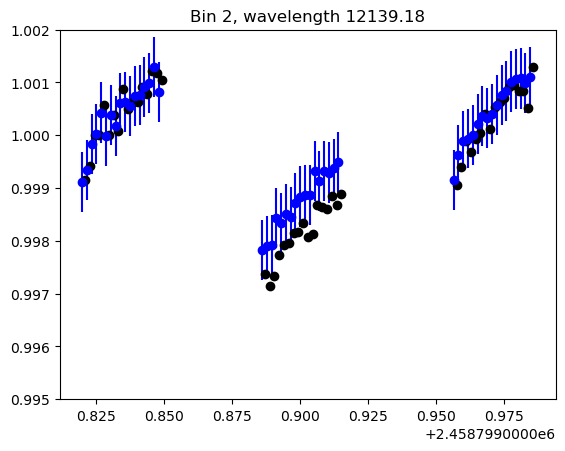

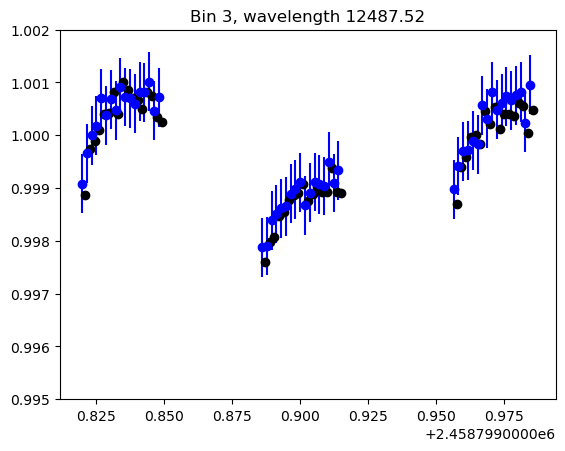

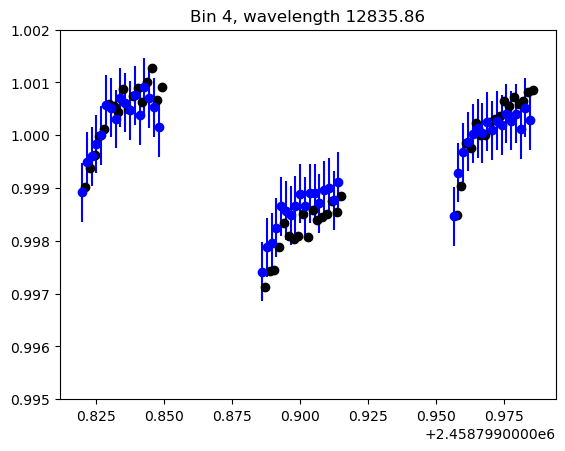

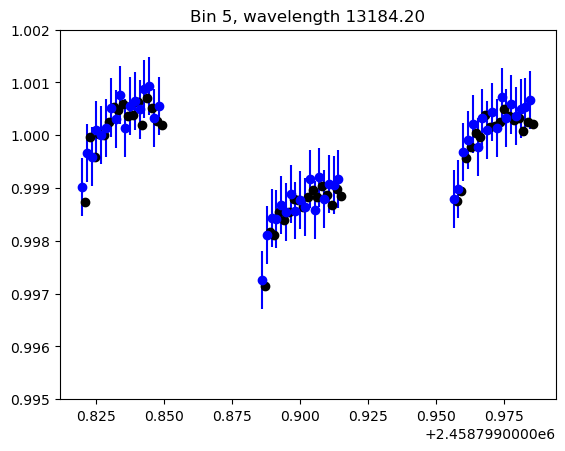

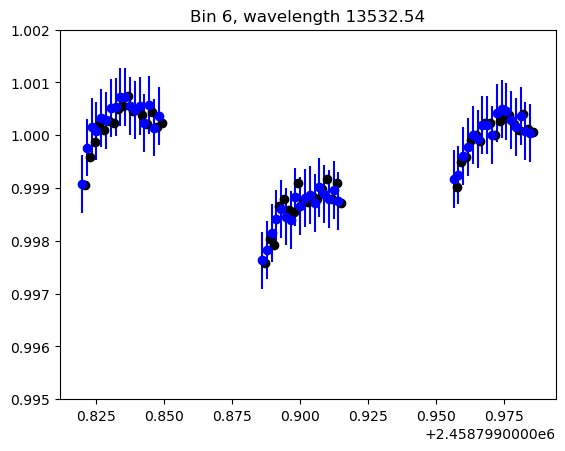

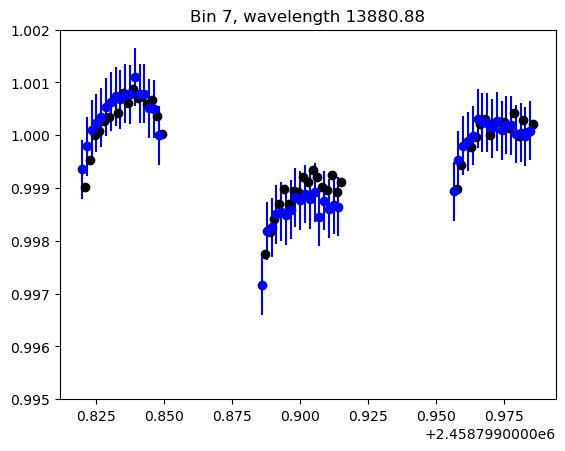

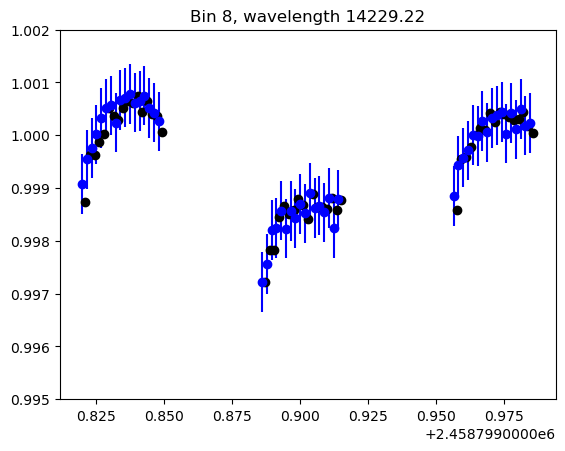

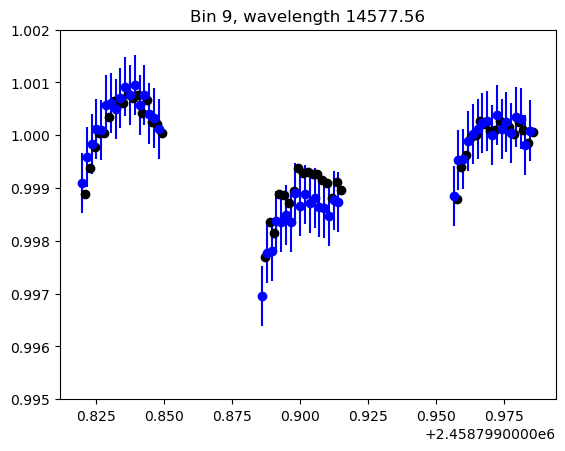

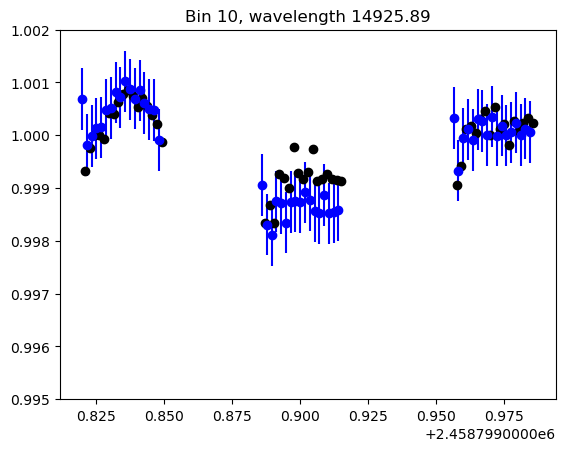

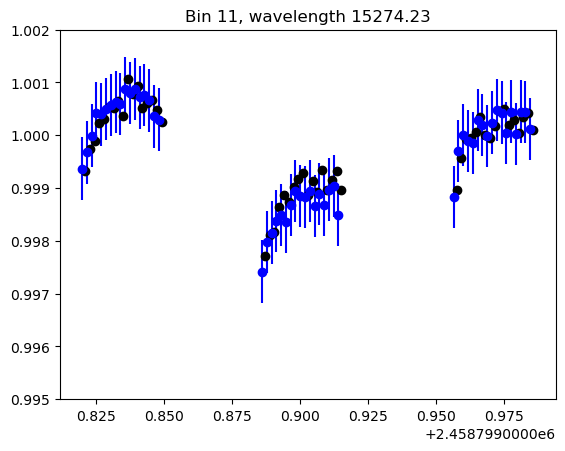

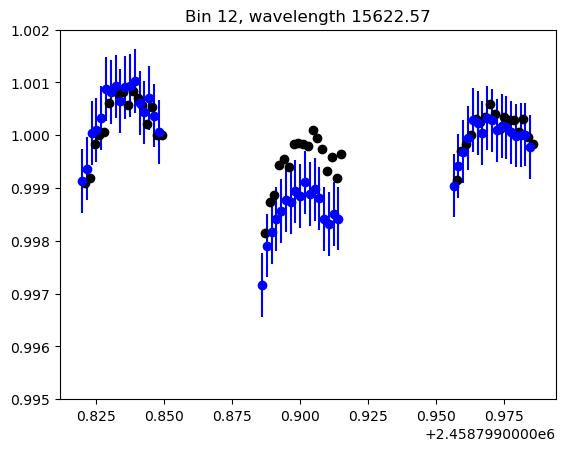

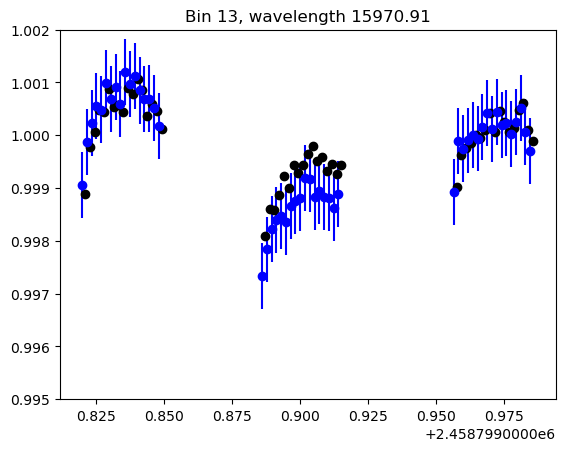

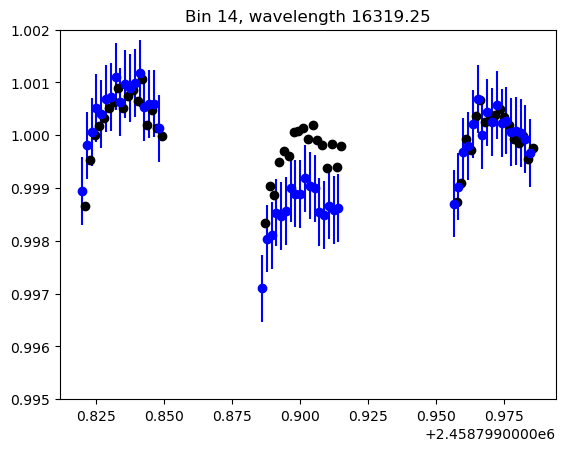

In [32]:
for i in range(normspec_o2.shape[1]):
    plt.title('Bin %d, wavelength %.2f'%(i, binnedwavs_o2[i]))
    plt.errorbar(fulltimes, fullnormspec[:,i], c='black', marker='o', ls='None')
    if loadTs:
        plt.errorbar(timesT, fluxesT[i,:], errorsT[i,:], c='blue', marker='o', ls='None')
#     plt.errorbar(orbit2_times, normspec_o2[:,i], normerrs_o2[:,i], ls='None', c='black', marker='o')
#     plt.errorbar(orbit3_times, normspec_o3[:,i], normerrs_o3[:,i], ls='None', marker='o')
#     plt.errorbar(orbit4_times, normspec_o4[:,i], normerrs_o4[:,i], ls='None', c='black', marker='o')
    plt.ylim((0.995, 1.002))
    plt.show()

In [ ]:
o3

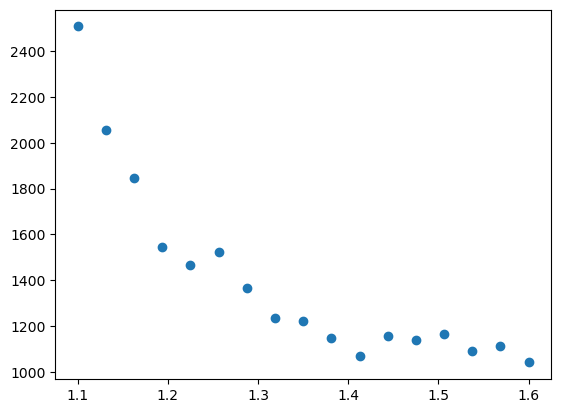

In [40]:
o3means = np.mean(fluxesT[:,17:34], axis=0)
estdepths = 1. - o3means
estwaves = np.linspace(1.1, 1.6, len(estdepths))
meandepth = np.mean(estdepths)
reldepths = estdepths - meandepth

ld = (0.04192)**2

#plt.axhline(ld*1.e6, c='black', alpha=0.4)
#plt.axhline(2090, c='black', alpha=0.4)
plt.scatter(estwaves, estdepths*1.e6)
plt.show()

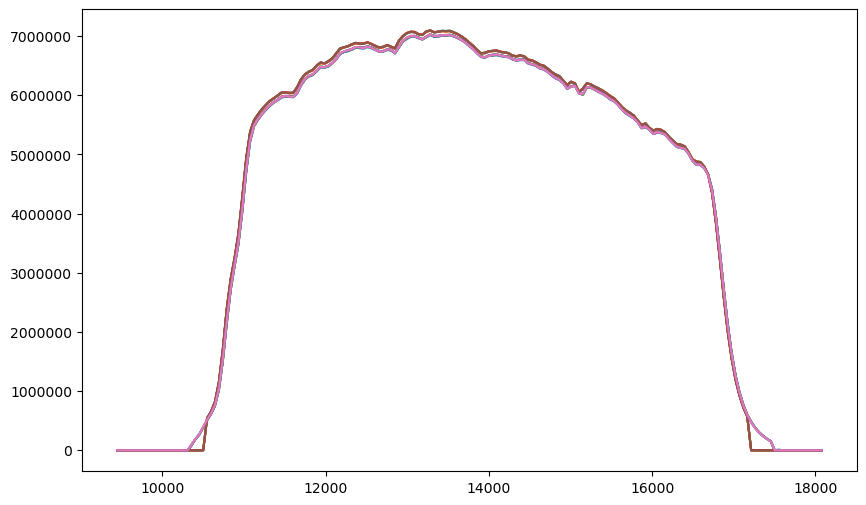

In [21]:
# plt.figure(figsize=(10,6))
# for img in range(orbit2_1Dspectra_firstsubexp.shape[0]):
#     y = orbit2_1Dspectra_firstsubexp[img]
#     #x = np.arange(len(y))
#     x = orbit2_wavelengths
# #     if img % 2 != 0:
# #         x = x - 1
# #         x[80:] = x[80:] - 0.
#     plt.plot(x,y, label='img')
# plt.show()

# Plotting the subexp-wise combined 1D spectra
plt.figure(figsize=(10,6))
for img in range(orbit2_1Dspectra.shape[0]):
    y = orbit2_1Dspectra[img]
    #x = np.arange(len(y))
    x = orbit2_wavelengths
    plt.plot(x,y, label='img')
plt.show()

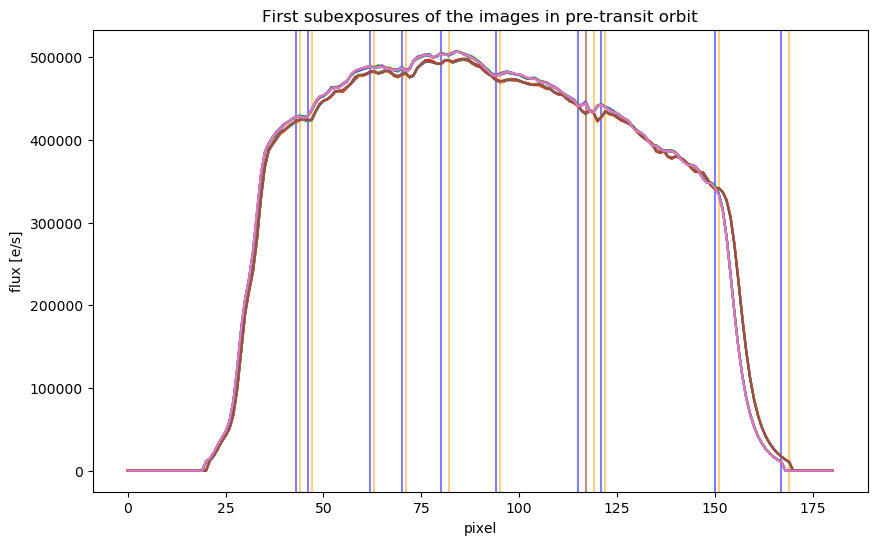

In [16]:
peven = np.array([43, 46, 62, 70, 80, 94, 115, 117, 121, 150, 167])  # for images 0,2,4,...
podd = np.array([44, 47, 63, 71, 82, 95, 117, 119, 122, 151, 169])  # for images 1,3,5...
plt.figure(figsize=(10,6))
plt.title('First subexposures of the images in pre-transit orbit')
for val in peven:
    plt.axvline(val, c='blue', alpha=0.5)
for val in podd:
    plt.axvline(val, c='orange', alpha=0.5)
for img in range(orbit2_1Dspectra_firstsubexp.shape[0]):
    y = orbit2_1Dspectra_firstsubexp[img]
    #x = np.arange(len(y))
    x = np.arange(len(y))
    plt.plot(x,y, label=img)

plt.xlabel('pixel')
plt.ylabel('flux [e/s]')
#plt.legend(loc='best', ncol=3)
plt.show()

-1.842685811717253e-06 0.0006305528304224437 0.9285915858960151 1.2062373474205699


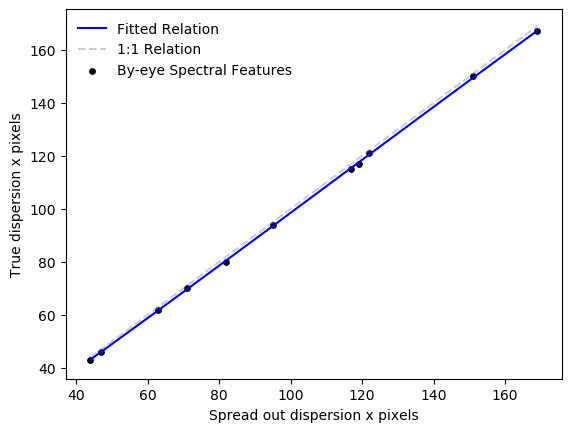

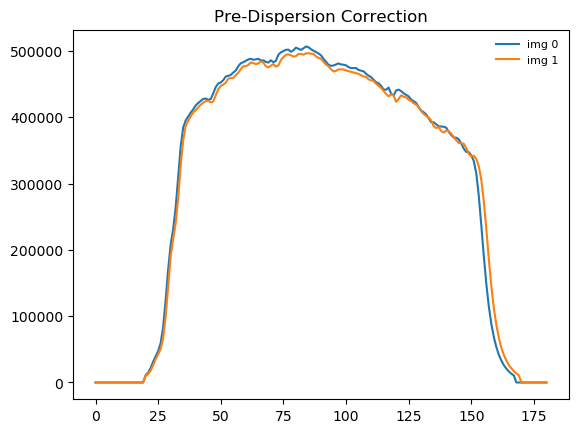

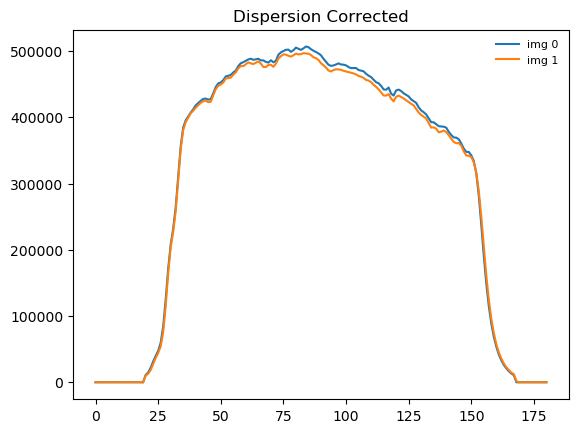

In [17]:
yy = orbit2_1Dspectra_firstsubexp[0]
xx = np.arange(len(yy))

p3, p2, p1, p0 = -1.842685811717253e-06, 0.0006305528304224437, 0.9285915858960151, 1.2062373474205699
#p3, p2, p1, p0 = np.polyfit(podd, peven, deg=3)
print(p3, p2, p1, p0)
pcorr = p3*(podd**3) + p2*(podd**2) + p1*(podd) + p0
xcorr = p3*(xx**3) + p2*(xx**2) + p1*(xx) + p0

plt.plot(podd, pcorr, c='blue', label='Fitted Relation')
plt.plot(podd, podd, c='gray', ls='--', alpha=0.4, label='1:1 Relation')
plt.scatter(podd, peven, s=15, c='black', label='By-eye Spectral Features')
plt.xlabel('Spread out dispersion x pixels')
plt.ylabel('True dispersion x pixels')
plt.legend(loc='upper left', frameon=False)
plt.show()

xinterp = np.zeros(len(xcorr)+2)
yinterp = np.zeros(len(xcorr)+2)
for xidx in range(len(xinterp)):
    if xidx == 0:
        continue
    if xidx == len(xinterp)-1:
        xinterp[xidx] = 180.
        continue
    else:
        xinterp[xidx] = xcorr[xidx-1]
        yinterp[xidx] = orbit2_1Dspectra_firstsubexp[1][xidx-1]
        
spec_interp = interp1d(xinterp, yinterp, kind='quadratic')
y_interpcorr = spec_interp(xx)

plt.title('Pre-Dispersion Correction')
plt.plot(xx, orbit2_1Dspectra_firstsubexp[0], label='img 0')
plt.plot(xx, orbit2_1Dspectra_firstsubexp[1], label='img 1')
plt.legend(loc='best', frameon=False, fontsize=8)
plt.show()

plt.title('Dispersion Corrected')
plt.plot(xx, orbit2_1Dspectra_firstsubexp[0], label='img 0')
plt.plot(xx, y_interpcorr, label='img 1')
#plt.plot(xcorr, orbit2_1Dspectra_firstsubexp[1])
plt.legend(loc='best', frameon=False, fontsize=8)
plt.show()

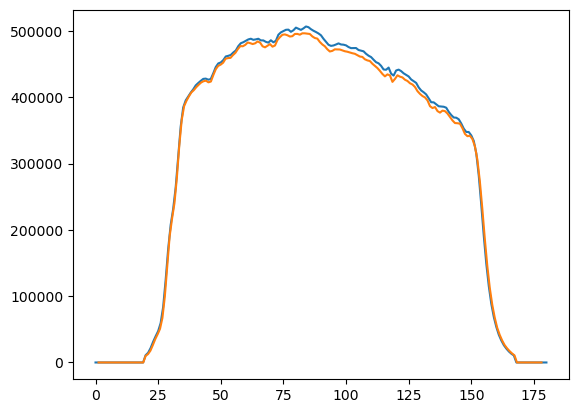

In [30]:
plt.plot(xx, orbit2_1Dspectra_firstsubexp[0])
plt.plot(xcorr, orbit2_1Dspectra_firstsubexp[1])
plt.show()

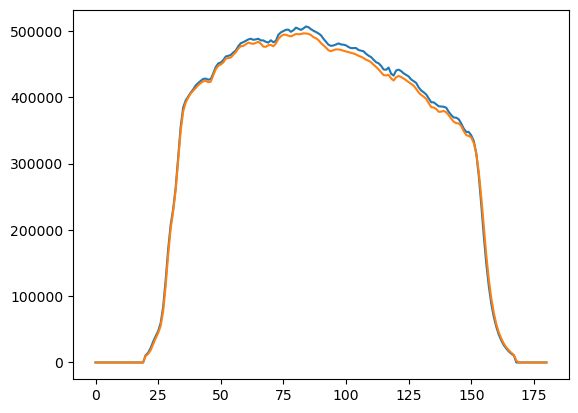

In [39]:
plt.plot(xx, orbit2_1Dspectra_firstsubexp[0])
plt.plot(xx, y_interpcorr)
#plt.plot(xcorr, orbit2_1Dspectra_firstsubexp[1])
plt.show()

In [31]:
len(xcorr)

181

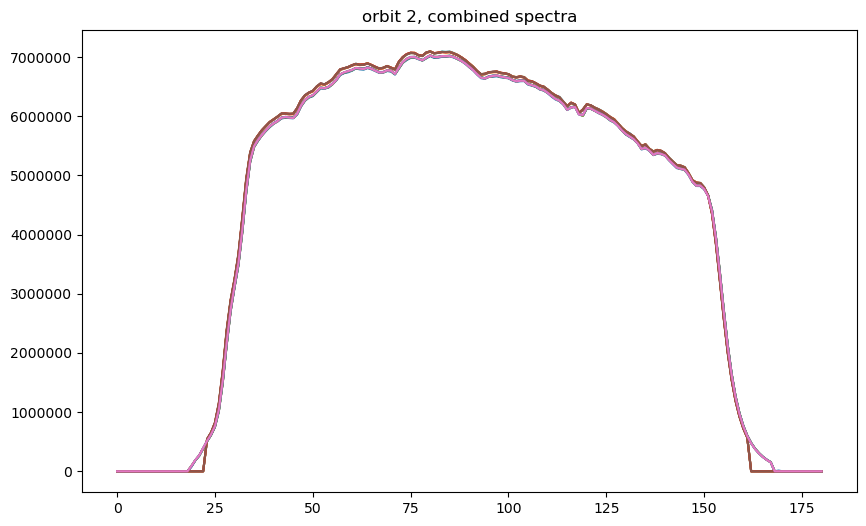

In [51]:
plt.figure(figsize=(10,6))
plt.title('orbit 2, combined spectra')
for img in range(orbit2_1Dspectra.shape[0]):
    y = orbit2_1Dspectra[img]
    x = np.arange(len(y))
    plt.plot(x,y, label='img')
plt.show()

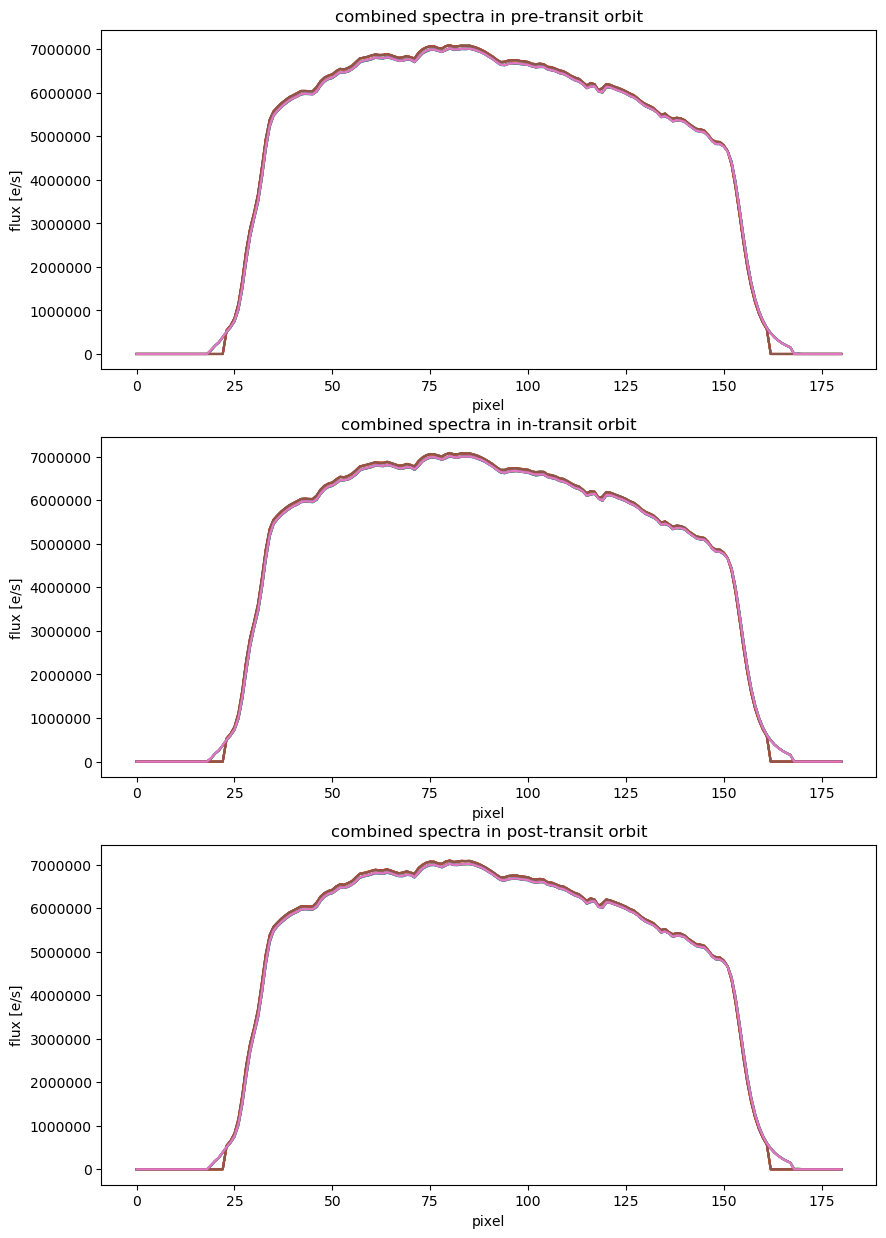

In [52]:
fig, ax = plt.subplots(figsize=(10,15), nrows=3)
ax[0].set_title('combined spectra in pre-transit orbit')
ax[1].set_title('combined spectra in in-transit orbit')
ax[2].set_title('combined spectra in post-transit orbit')
for img in range(orbit2_1Dspectra.shape[0]):
    y = orbit2_1Dspectra[img]
    #x = np.arange(len(y))
    x = np.arange(len(y))
    ax[0].plot(x,y, label=img)
ax[0].set_xlabel('pixel')
ax[0].set_ylabel('flux [e/s]')
for img in range(orbit3_1Dspectra.shape[0]):
    y = orbit3_1Dspectra[img]
    #x = np.arange(len(y))
    x = np.arange(len(y))
    ax[1].plot(x,y, label=img)
ax[1].set_xlabel('pixel')
ax[1].set_ylabel('flux [e/s]')
for img in range(orbit4_1Dspectra.shape[0]):
    y = orbit4_1Dspectra[img]
    #x = np.arange(len(y))
    x = np.arange(len(y))
    ax[2].plot(x,y, label=img)
ax[2].set_xlabel('pixel')
ax[2].set_ylabel('flux [e/s]')
#plt.legend(loc='best', ncol=3)
plt.show()

Loading in the direct images, and setting up the wavelength calibration function

In [53]:
o1directimg = '/home/mmmurphy/data/hd219666b/hst_images/idz205j2q_ima.fits'
o2directimg = '/home/mmmurphy/data/hd219666b/hst_images/idz206jvq_ima.fits'
o3directimg = '/home/mmmurphy/data/hd219666b/hst_images/idz207koq_ima.fits'
o4directimg = '/home/mmmurphy/data/hd219666b/hst_images/idz208lhq_ima.fits'
wsparams_o1 = ext.WavelengthSolution(o1directimg)
wsparams_o2 = ext.WavelengthSolution(o2directimg)
wsparams_o3 = ext.WavelengthSolution(o3directimg)
wsparams_o4 = ext.WavelengthSolution(o4directimg)
full_dispaxis = np.arange(522.0)
waveFunc_o1 = wsparams_o1[0] + wsparams_o1[1]*(full_dispaxis - wsparams_o1[2])
waveFunc_o2 = wsparams_o2[0] + wsparams_o2[1]*(full_dispaxis - wsparams_o2[2])
waveFunc_o3 = wsparams_o3[0] + wsparams_o3[1]*(full_dispaxis - wsparams_o3[2])
waveFunc_o4 = wsparams_o4[0] + wsparams_o4[1]*(full_dispaxis - wsparams_o4[2])

# I believe that waveInterp(wavelength in angstrom) returns the pixel value for that wavelength
waveInterp_o1 = interp1d(waveFunc_o1, full_dispaxis, kind='linear')
waveInterp_o2 = interp1d(waveFunc_o2, full_dispaxis, kind='linear')
waveInterp_o3 = interp1d(waveFunc_o3, full_dispaxis, kind='linear')
waveInterp_o4 = interp1d(waveFunc_o4, full_dispaxis, kind='linear')

In [54]:
fullpixs_o1 = np.arange(orbit1_spectral_xlimits[0][0], orbit1_spectral_xlimits[0][1], 1)
fullpixs_o2 = np.arange(orbit2_spectral_xlimits[0][0], orbit2_spectral_xlimits[0][1], 1)
fullpixs_o3 = np.arange(orbit3_spectral_xlimits[0][0], orbit3_spectral_xlimits[0][1], 1)
fullpixs_o4 = np.arange(orbit4_spectral_xlimits[0][0], orbit4_spectral_xlimits[0][1], 1)

# pixs_o1_even, pixs_o1_odd = fullpixs_o1, (x_corrected - x_true) + fullpixs_o1
# pixs_o2_even, pixs_o2_odd = fullpixs_o2, (x_corrected - x_true) + fullpixs_o2
# pixs_o3_even, pixs_o3_odd = fullpixs_o3, (x_corrected - x_true) + fullpixs_o3
# pixs_o4_even, pixs_o4_odd = fullpixs_o4, (x_corrected - x_true) + fullpixs_o4

In [55]:
fullpixs_o1 = np.arange(orbit1_spectral_xlimits[0][0], orbit1_spectral_xlimits[0][1], 1)
fullpixs_o2 = np.arange(orbit2_spectral_xlimits[0][0], orbit2_spectral_xlimits[0][1], 1)
fullpixs_o3 = np.arange(orbit3_spectral_xlimits[0][0], orbit3_spectral_xlimits[0][1], 1)
fullpixs_o4 = np.arange(orbit4_spectral_xlimits[0][0], orbit4_spectral_xlimits[0][1], 1)

temp_wavs = np.linspace(9000, 18000, 500)   # wide range that encompasses the WFC3/G141 wavelength range
temp_pixs_o1 = waveInterp_o1(temp_wavs)
temp_pixs_o2 = waveInterp_o2(temp_wavs)
temp_pixs_o3 = waveInterp_o3(temp_wavs)
temp_pixs_o4 = waveInterp_o4(temp_wavs)

# fit line with x = pixs and y = wavs; y = mx + b
m1, b1 = np.polyfit(x=temp_pixs_o1, y=temp_wavs, deg=1)
m2, b2 = np.polyfit(x=temp_pixs_o2, y=temp_wavs, deg=1)
m3, b3 = np.polyfit(x=temp_pixs_o3, y=temp_wavs, deg=1)
m4, b4 = np.polyfit(x=temp_pixs_o4, y=temp_wavs, deg=1)

# now re-solve
wavs_o1 = m1*fullpixs_o1 + b1
wavs_o2 = m2*fullpixs_o2 + b2
wavs_o3 = m3*fullpixs_o3 + b3
wavs_o4 = m4*fullpixs_o4 + b4
# wavs_o1_even, wavs_o1_odd = m1*pixs_o1_even + b1, m1*pixs_o1_odd + b1
# wavs_o2_even, wavs_o2_odd = m2*pixs_o2_even + b2, m2*pixs_o2_odd + b2
# wavs_o3_even, wavs_o3_odd = m3*pixs_o3_even + b3, m3*pixs_o3_odd + b3
# wavs_o4_even, wavs_o4_odd = m4*pixs_o4_even + b4, m4*pixs_o4_odd + b4

# # Plotting the wavelength calibration
# plt.figure(figsize=(4,4))
# plt.plot(fullpixs_o1, wavs_o1_even, label='Orbit 1')
# plt.plot(fullpixs_o2, wavs_o2_even, label='Orbit 2')
# plt.plot(fullpixs_o3, wavs_o3_even, label='Orbit 3')
# plt.plot(fullpixs_o4, wavs_o4_even, label='Orbit 4')
# plt.xlabel('Pixel on Full Detector')
# plt.ylabel('Wavelength [angstrom]')
# plt.legend(loc='best', fontsize=8, frameon=False)
# plt.show()

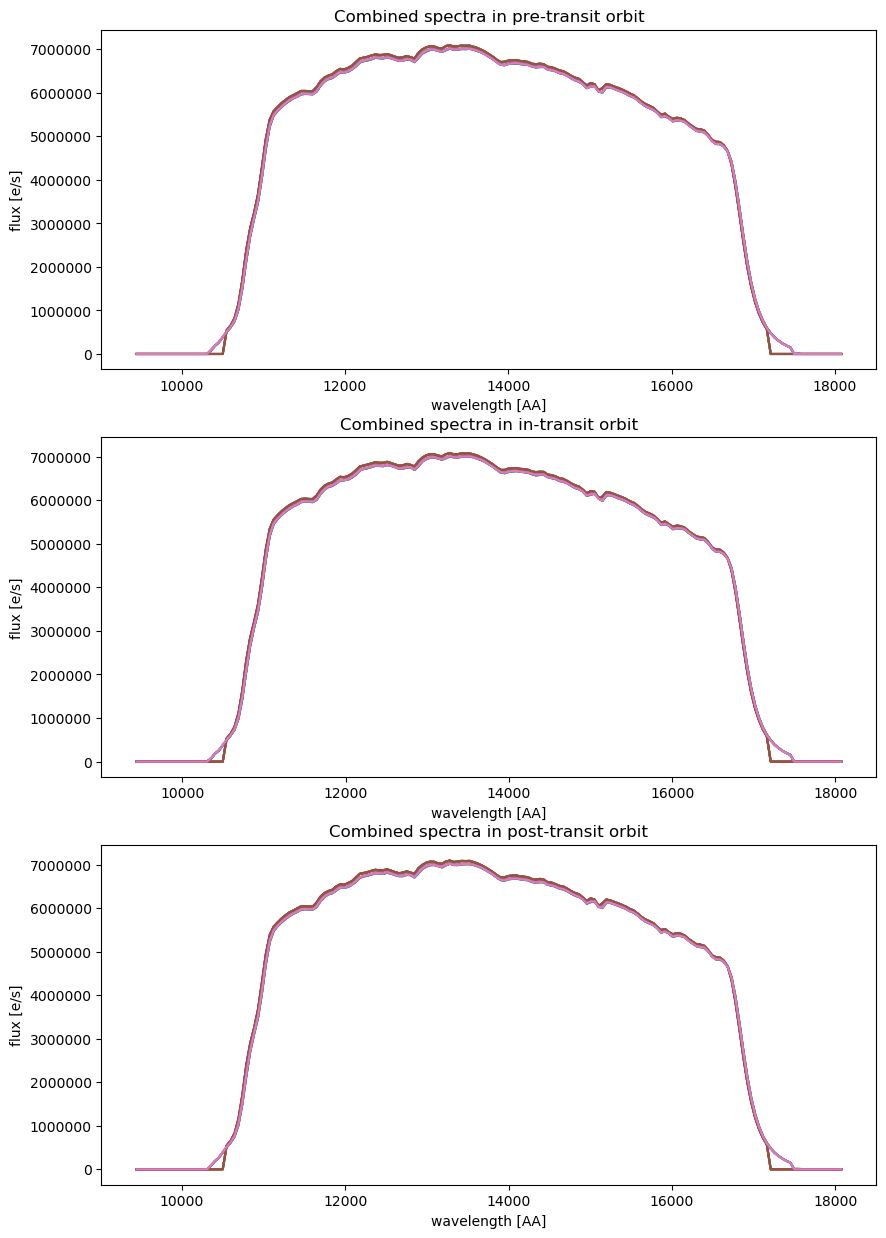

In [57]:
fig, ax = plt.subplots(figsize=(10,15), nrows=3)
ax[0].set_title('Combined spectra in pre-transit orbit')
ax[1].set_title('Combined spectra in in-transit orbit')
ax[2].set_title('Combined spectra in post-transit orbit')
for img in range(orbit2_1Dspectra.shape[0]):
    y = orbit2_1Dspectra[img]
    #x = np.arange(len(y))
    x = wavs_o2
    ax[0].plot(x,y, label=img)
ax[0].set_xlabel('wavelength [AA]')
ax[0].set_ylabel('flux [e/s]')
for img in range(orbit3_1Dspectra.shape[0]):
    y = orbit3_1Dspectra[img]
    #x = np.arange(len(y))
    x = wavs_o3
    ax[1].plot(x,y, label=img)
ax[1].set_xlabel('wavelength [AA]')
ax[1].set_ylabel('flux [e/s]')
for img in range(orbit4_1Dspectra.shape[0]):
    y = orbit4_1Dspectra[img]
    #x = np.arange(len(y))
    x = wavs_o4
    ax[2].plot(x,y, label=img)
ax[2].set_xlabel('wavelength [AA]')
ax[2].set_ylabel('flux [e/s]')
#plt.legend(loc='best', ncol=3)
plt.show()

In [58]:
def binspectrum(x_axis, spectrum, specerrors, Nbins):
    
    bin_edges = np.linspace(x_axis[0], x_axis[-1], Nbins+1, endpoint=True)
    #print(bin_edges)
    bin_identities = np.digitize(x_axis, bin_edges) - 1
    #print(bin_identities)
    
    spectrum_binned = np.zeros(Nbins)
    specerrs_binned = np.zeros(Nbins)
    bin_midxs = np.zeros(Nbins) 
    i = 0
    while i <= (Nbins - 1):
        bin_member_idxs = np.where(bin_identities == i)[0]
        member_specvals = spectrum[bin_member_idxs]
        member_errsvals = specerrors[bin_member_idxs]
        
        bin_specval = np.sum(member_specvals)
        bin_errsval = np.median(member_errsvals) / np.sqrt(len(member_errsvals))
        spectrum_binned[i] = bin_specval
        specerrs_binned[i] = bin_errsval
        
        try:
            # works until i = Nbins
            bin_midxs[i] = np.median([bin_edges[i], bin_edges[i+1]])
        except IndexError:
            lastbin_width = abs(x_axis[-1] - bin_edges[i])
            bin_midxs[i] = np.median([bin_edges[i], bin_edges[i]+lastbin_width])
        
        i += 1
    

    return bin_midxs, spectrum_binned, specerrs_binned

In [65]:
spec_o1, errs_o1 = np.copy(orbit1_1Dspectra), np.copy(orbit1_1Dspectrauncs)
spec_o2, errs_o2 = np.copy(orbit2_1Dspectra), np.copy(orbit2_1Dspectrauncs)
spec_o3, errs_o3 = np.copy(orbit3_1Dspectra), np.copy(orbit3_1Dspectrauncs)
spec_o4, errs_o4 = np.copy(orbit4_1Dspectra), np.copy(orbit4_1Dspectrauncs)

# Defining the number of bins to use
Nbins = 14
# We extracted more wavelengths than are to be used, as the edges go over the filter's response
#   so we need to slightly trim our spectra
G141_minwav = 11250.
G141_maxwav = 16500.
o1_goodwav_idxs = np.where((wavs_o1 >= G141_minwav) & (wavs_o1 <= G141_maxwav))[0]
o2_goodwav_idxs = np.where((wavs_o2 >= G141_minwav) & (wavs_o2 <= G141_maxwav))[0]
o3_goodwav_idxs = np.where((wavs_o3 >= G141_minwav) & (wavs_o3 <= G141_maxwav))[0]
o4_goodwav_idxs = np.where((wavs_o4 >= G141_minwav) & (wavs_o4 <= G141_maxwav))[0]

waves_o1 = wavs_o1[o1_goodwav_idxs]
waves_o2 = wavs_o2[o2_goodwav_idxs]
waves_o3 = wavs_o3[o3_goodwav_idxs]
waves_o4 = wavs_o4[o4_goodwav_idxs]

trimmed_spec_o1, trimmed_errs_o1 = np.zeros((spec_o1.shape[0], len(waves_o1))), np.zeros((spec_o1.shape[0], len(waves_o1)))
trimmed_spec_o2, trimmed_errs_o2 = np.zeros((spec_o2.shape[0], len(waves_o2))), np.zeros((spec_o2.shape[0], len(waves_o2)))
trimmed_spec_o3, trimmed_errs_o3 = np.zeros((spec_o3.shape[0], len(waves_o3))), np.zeros((spec_o3.shape[0], len(waves_o3)))
trimmed_spec_o4, trimmed_errs_o4 = np.zeros((spec_o4.shape[0], len(waves_o4))), np.zeros((spec_o4.shape[0], len(waves_o4)))

for img in range(spec_o1.shape[0]):
    # luckily, each orbit has the same number of images so i only need to do one loop
    
    trimmed_spec_o1[img], trimmed_errs_o1[img] = spec_o1[img][o1_goodwav_idxs], errs_o1[img][o1_goodwav_idxs]
    trimmed_spec_o2[img], trimmed_errs_o2[img] = spec_o2[img][o2_goodwav_idxs], errs_o2[img][o2_goodwav_idxs]
    trimmed_spec_o3[img], trimmed_errs_o3[img] = spec_o3[img][o3_goodwav_idxs], errs_o3[img][o3_goodwav_idxs]
    trimmed_spec_o4[img], trimmed_errs_o4[img] = spec_o4[img][o4_goodwav_idxs], errs_o4[img][o4_goodwav_idxs]
    
Nimages = spec_o1.shape[0]
binnedspec_o1, binnederrs_o1 = np.zeros((Nimages, Nbins)), np.zeros((Nimages, Nbins))
binnedspec_o2, binnederrs_o2 = np.zeros((Nimages, Nbins)), np.zeros((Nimages, Nbins))
binnedspec_o3, binnederrs_o3 = np.zeros((Nimages, Nbins)), np.zeros((Nimages, Nbins))
binnedspec_o4, binnederrs_o4 = np.zeros((Nimages, Nbins)), np.zeros((Nimages, Nbins))
for img in range(Nimages):
    binnedwavs_o1, binnedspec_o1[img], binnederrs_o1[img] = binspectrum(waves_o1, trimmed_spec_o1[img], trimmed_errs_o1[img], Nbins)
    binnedwavs_o2, binnedspec_o2[img], binnederrs_o2[img] = binspectrum(waves_o2, trimmed_spec_o2[img], trimmed_errs_o2[img], Nbins)
    binnedwavs_o3, binnedspec_o3[img], binnederrs_o3[img] = binspectrum(waves_o3, trimmed_spec_o3[img], trimmed_errs_o3[img], Nbins)
    binnedwavs_o4, binnedspec_o4[img], binnederrs_o4[img] = binspectrum(waves_o4, trimmed_spec_o4[img], trimmed_errs_o4[img], Nbins)

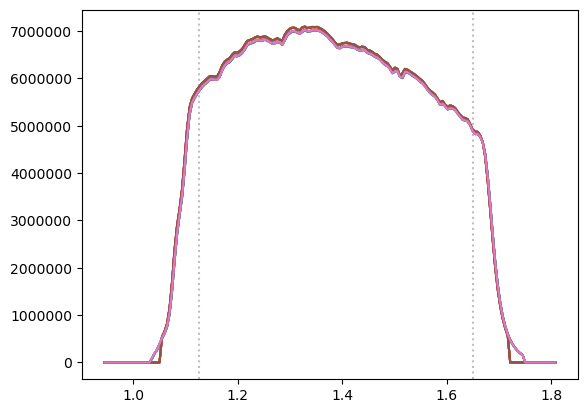

In [66]:
plt.axvline(G141_minwav/10000, ls='dotted', c='gray', alpha=0.5)
plt.axvline(G141_maxwav/10000, ls='dotted', c='gray', alpha=0.5)
for img in range(orbit2_1Dspectra.shape[0]):
    plt.plot(wavs_o2/10000., orbit2_1Dspectra[img], label=img)
    
# for img in range(orbit2_1Dspectra.shape[0]):
#     if (img % 2 == 0):
#         plt.plot(wavs_o2_even/10000., orbit2_1Dspectra[img], c='black')
#     else:
#         plt.plot(wavs_o2_odd/10000., orbit2_1Dspectra[img], c='black')

# # re-creating and plotting the bin-edges
# bin_edges = np.linspace(waves_o2[0], waves_o2[-1], Nbins+1, endpoint=True)
# plt.scatter(bin_edges/10000., [5.8e6]*len(bin_edges), c='gray', marker='s', alpha=0.75)
# plt.scatter(binnedwavs_o2/10000., [6e6]*len(binnedwavs_o2))

# zoom-in on set of featureson left side
# plt.xlim(1.1, 1.4)
# plt.ylim(6.5e6, 7.2e6)
# zoom-in on set of features on right side
# plt.xlim(1.35, 1.6)
# plt.ylim(5e6, 7e6)
plt.show()

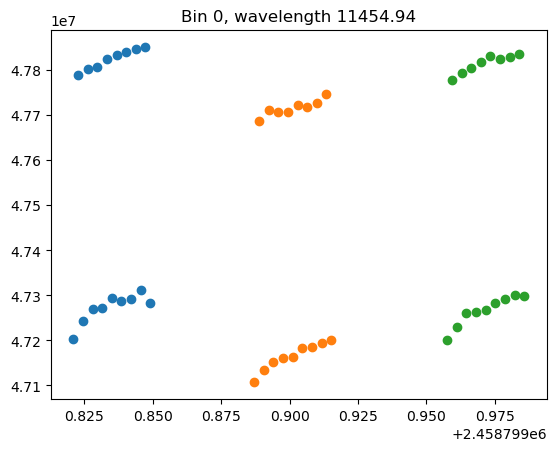

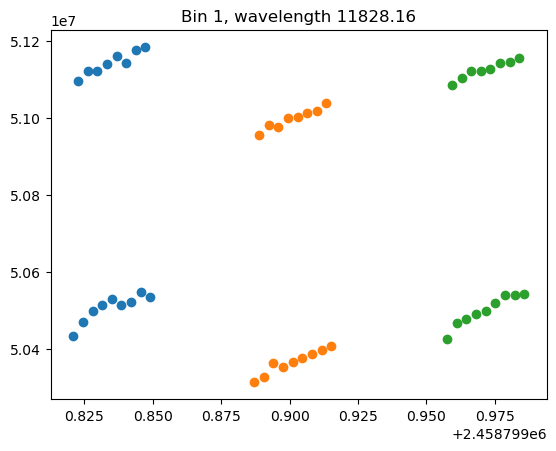

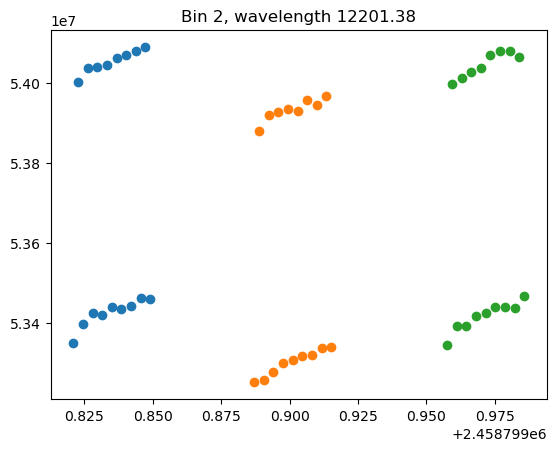

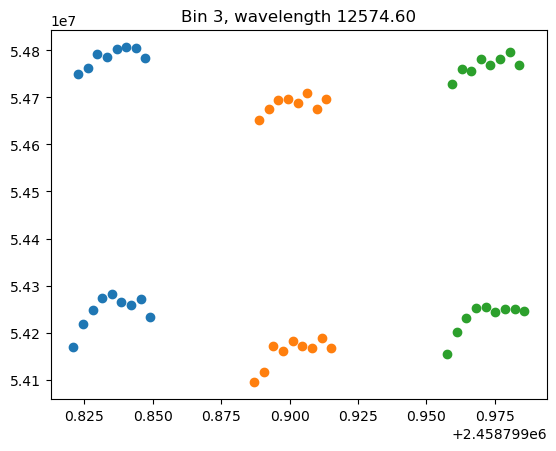

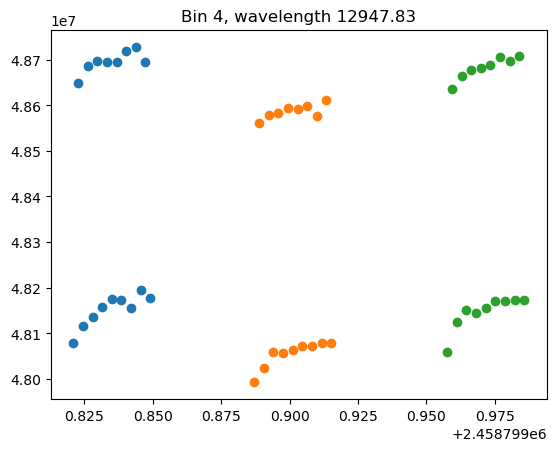

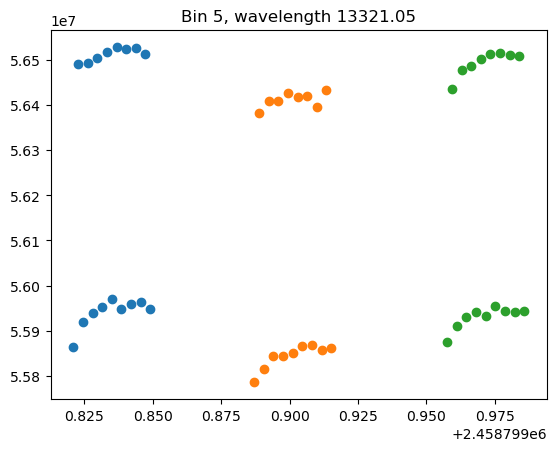

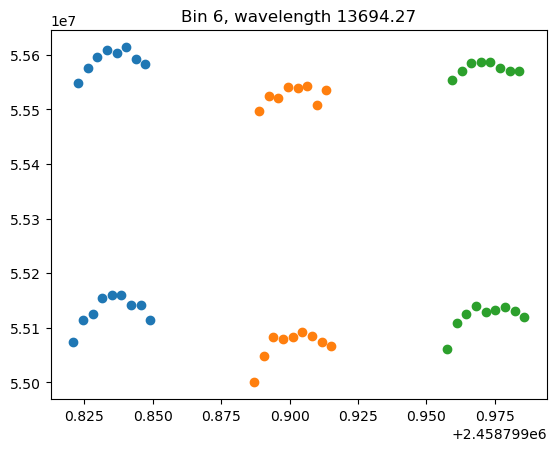

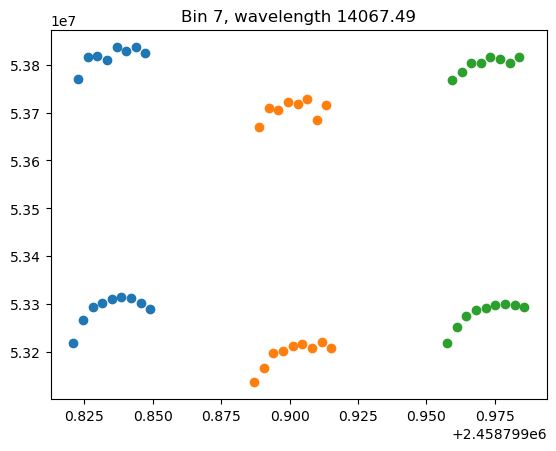

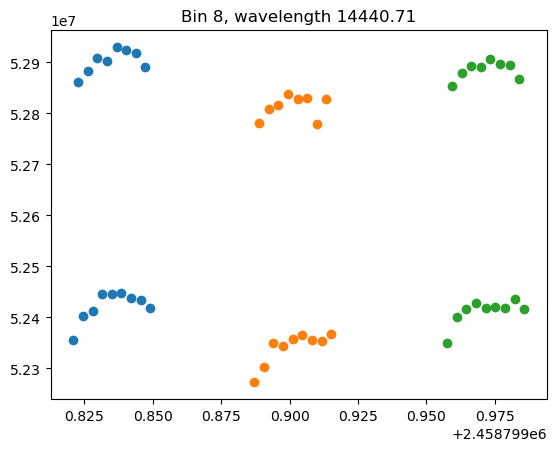

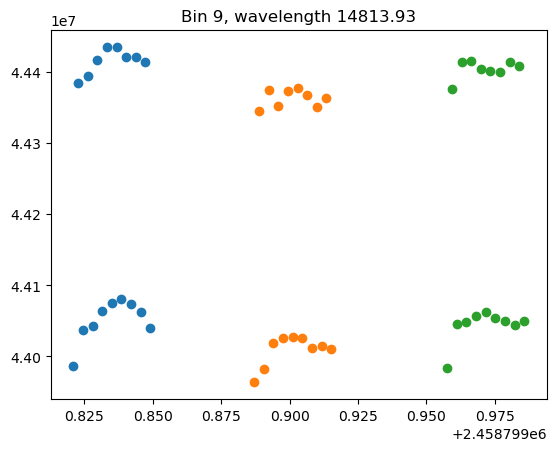

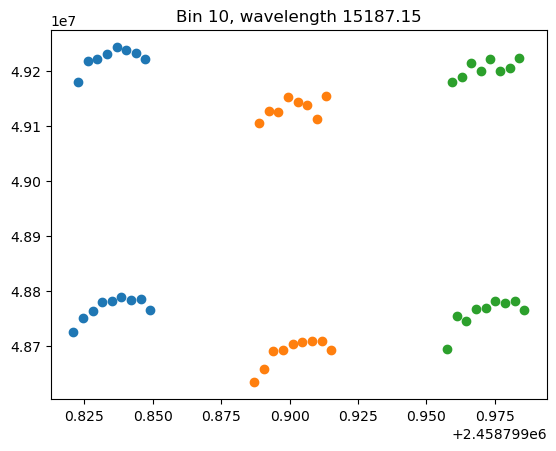

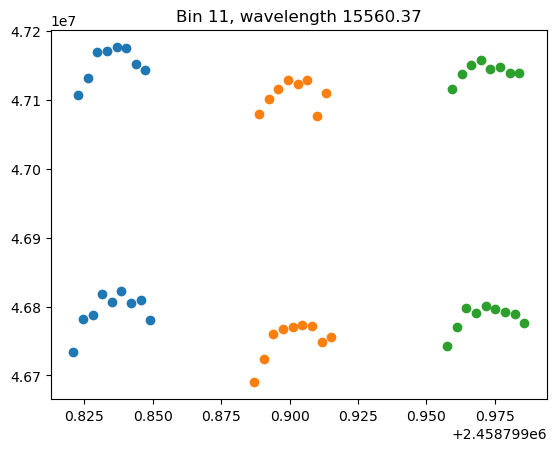

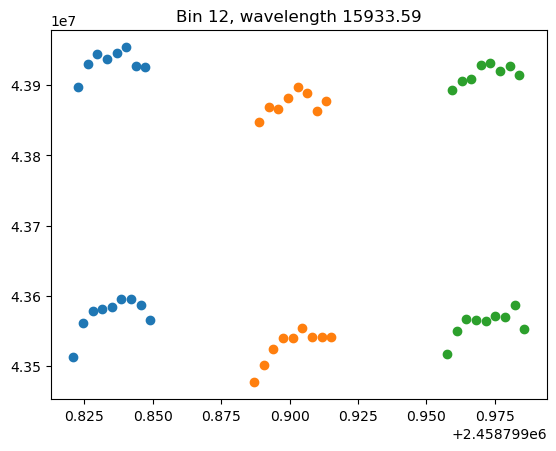

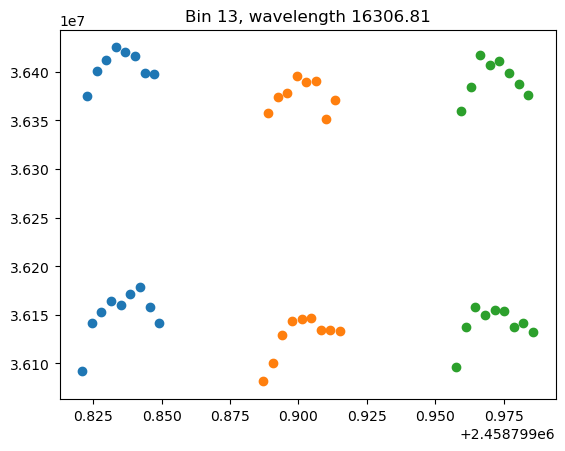

In [67]:
for i in range(binnedspec_o2.shape[1]):
    plt.title('Bin %d, wavelength %.2f'%(i, binnedwavs_o2[i]))
    plt.errorbar(orbit2_times, binnedspec_o2[:,i], binnederrs_o2[:,i], ls='None', marker='o')
    plt.errorbar(orbit3_times, binnedspec_o3[:,i], binnederrs_o3[:,i], ls='None', marker='o')
    plt.errorbar(orbit4_times, binnedspec_o4[:,i], binnederrs_o4[:,i], ls='None', marker='o')
    plt.show()

In [68]:
normspec_o2, normerrs_o2 = np.copy(binnedspec_o2), np.copy(binnederrs_o2)
normspec_o3, normerrs_o3 = np.copy(binnedspec_o3), np.copy(binnederrs_o3)
normspec_o4, normerrs_o4 = np.copy(binnedspec_o4), np.copy(binnederrs_o4)
for wav in range(Nbins):
    normval1 = np.max(binnedspec_o2[:,wav][::2])
    normval2 = np.max(binnedspec_o2[:,wav][1::2])
    
    normspec_o2[:,wav][::2] /= normval1
    normspec_o2[:,wav][1::2] /= normval2
    normerrs_o2[:,wav][::2] /= normval1
    normerrs_o2[:,wav][1::2] /= normval2
    
    normspec_o3[:,wav][::2] /= normval1
    normspec_o3[:,wav][1::2] /= normval2
    normerrs_o3[:,wav][::2] /= normval1
    normerrs_o3[:,wav][1::2] /= normval2    
    
    normspec_o4[:,wav][::2] /= normval1
    normspec_o4[:,wav][1::2] /= normval2
    normerrs_o4[:,wav][::2] /= normval1
    normerrs_o4[:,wav][1::2] /= normval2    

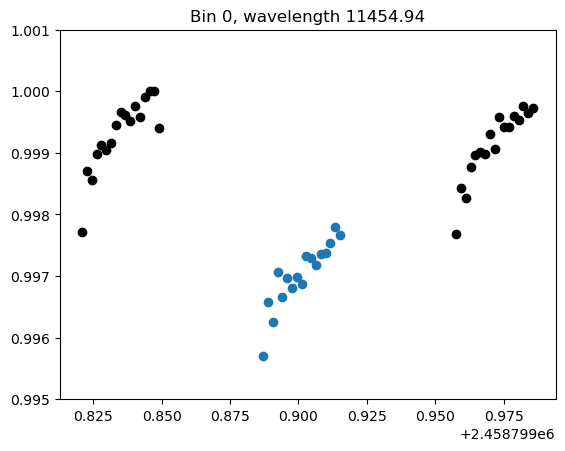

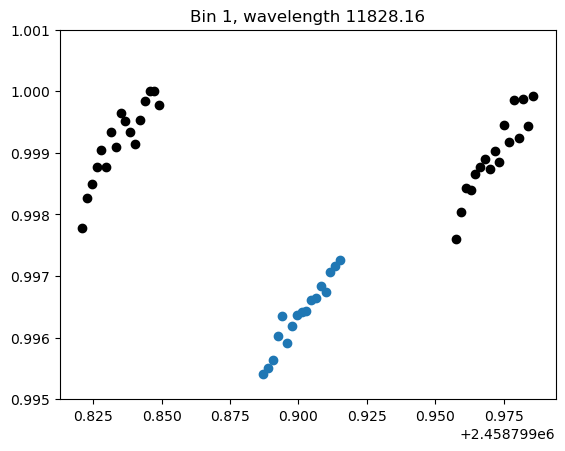

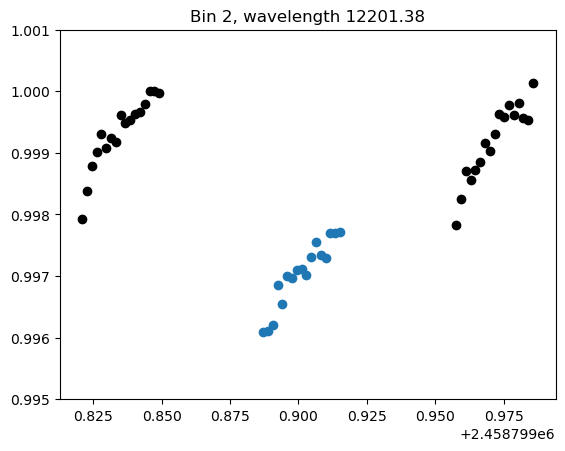

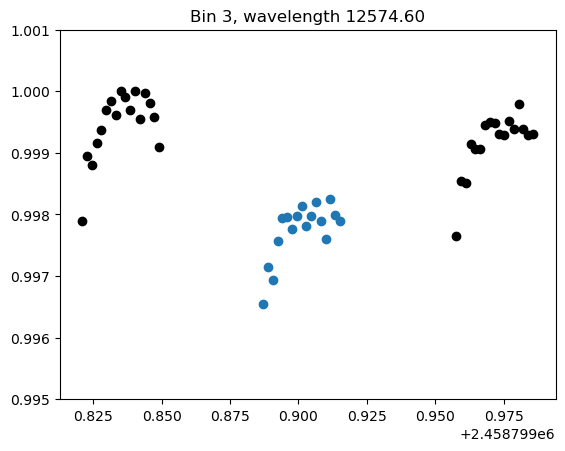

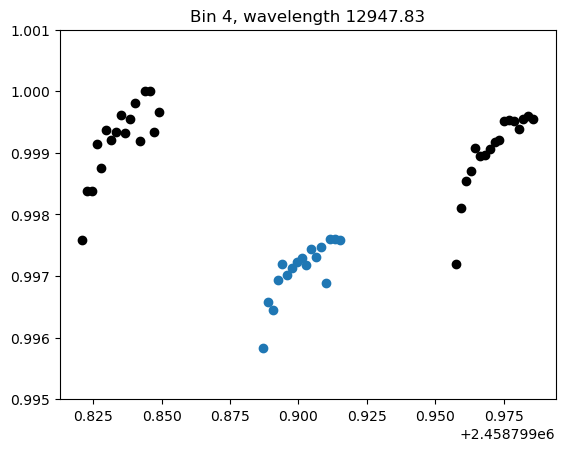

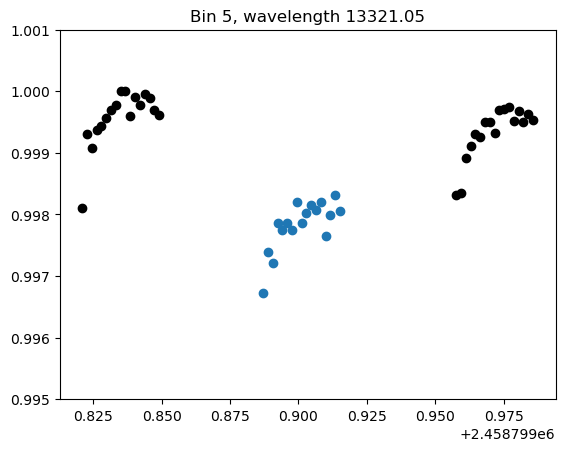

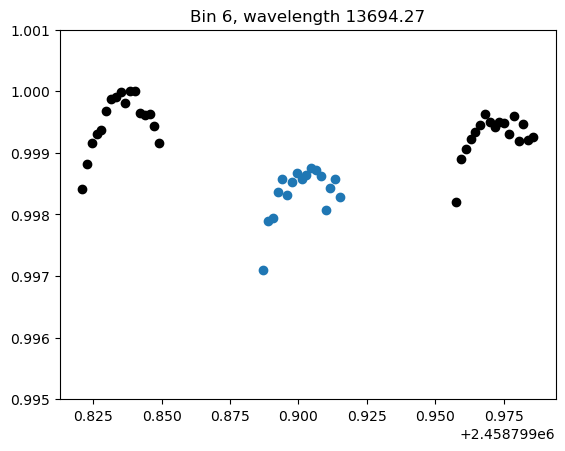

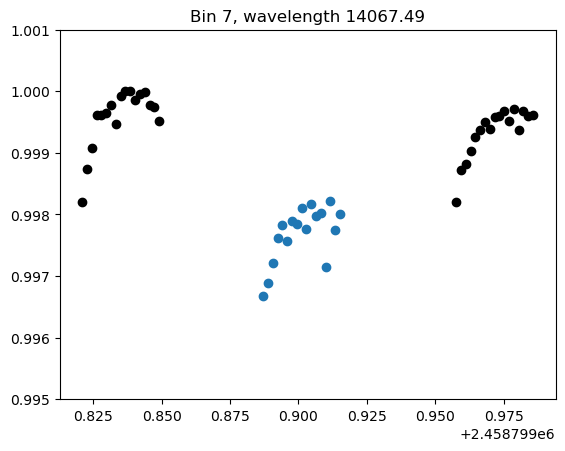

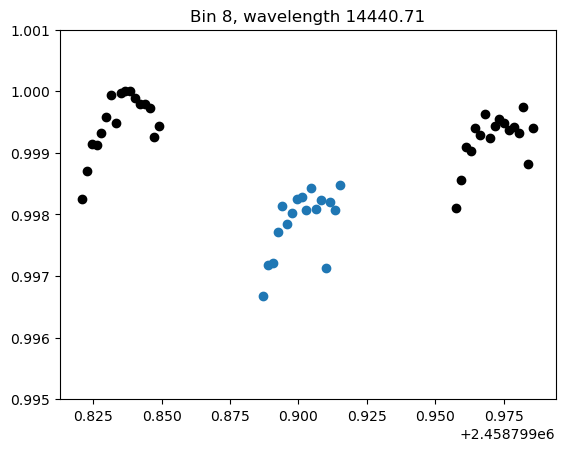

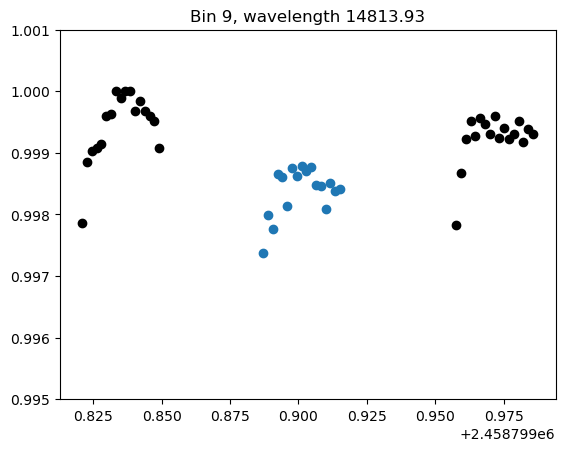

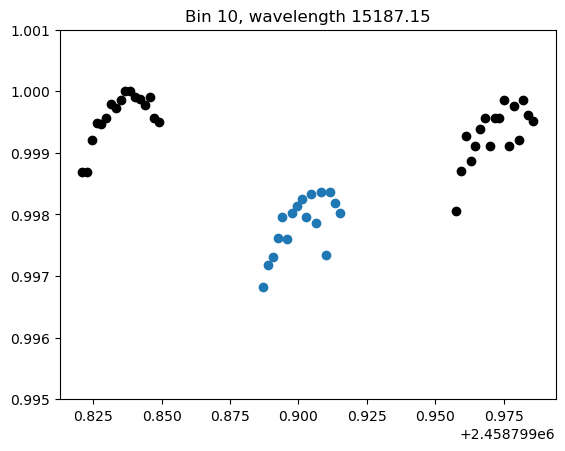

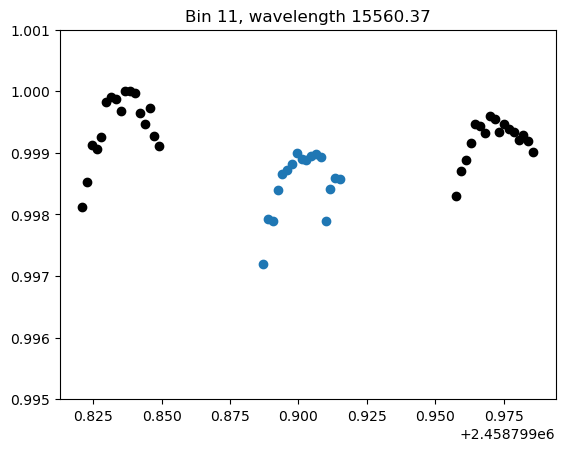

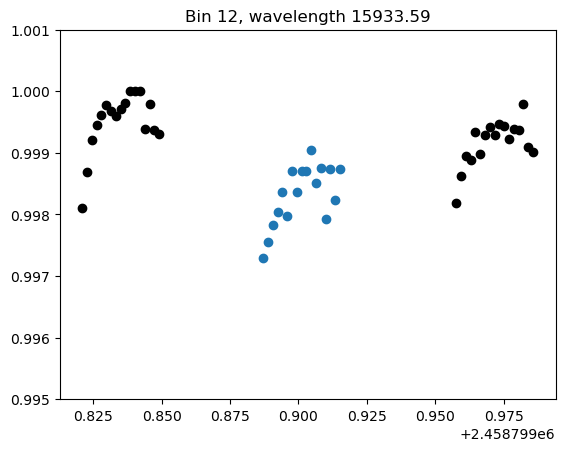

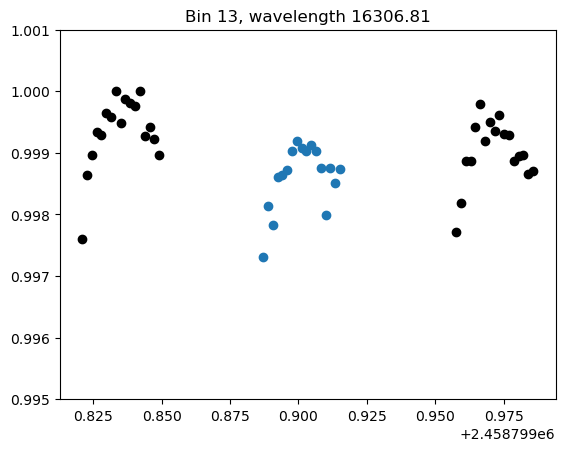

In [69]:
for i in range(normspec_o2.shape[1]):
    plt.title('Bin %d, wavelength %.2f'%(i, binnedwavs_o2[i]))
    plt.errorbar(orbit2_times, normspec_o2[:,i], normerrs_o2[:,i], ls='None', c='black', marker='o')
    plt.errorbar(orbit3_times, normspec_o3[:,i], normerrs_o3[:,i], ls='None', marker='o')
    plt.errorbar(orbit4_times, normspec_o4[:,i], normerrs_o4[:,i], ls='None', c='black', marker='o')
    plt.ylim((0.995, 1.001))
    plt.show()

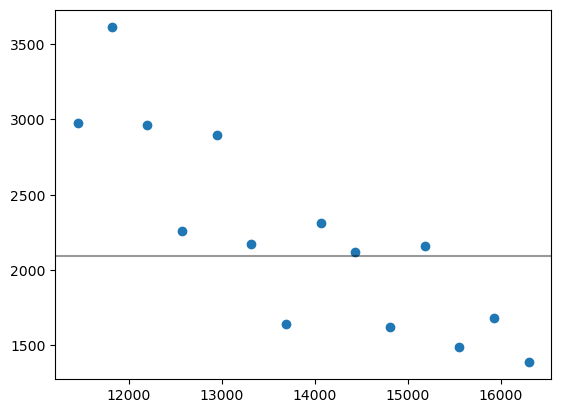

array([0.99691398, 0.99780374, 0.99801586, 0.9984286 ])

In [22]:
saveData = True
if saveData:
    datapath = '/home/mmmurphy/data/hd219666b/reduced_data/'
    np.savez(datapath+'orbit1_extractedrawdata.npz', times=orbit1_times, broadbandflux=orbit1_broadbands, broadbanderrs=orbit1_broadbands_uncs,
            spectra1D=orbit1_1Dspectra, errs1D=orbit1_1Dspectrauncs, spectral_xlimits=orbit1_spectral_xlimits)
    np.savez(datapath+'orbit2_extractedrawdata.npz', times=orbit2_times, broadbandflux=orbit2_broadbands, broadbanderrs=orbit2_broadbands_uncs,
            spectra1D=orbit2_1Dspectra, errs1D=orbit2_1Dspectrauncs, spectral_xlimits=orbit2_spectral_xlimits)
    np.savez(datapath+'orbit3_extractedrawdata.npz', times=orbit3_times, broadbandflux=orbit3_broadbands, broadbanderrs=orbit3_broadbands_uncs,
            spectra1D=orbit3_1Dspectra, errs1D=orbit3_1Dspectrauncs, spectral_xlimits=orbit3_spectral_xlimits)
    np.savez(datapath+'orbit4_extractedrawdata.npz', times=orbit4_times, broadbandflux=orbit4_broadbands, broadbanderrs=orbit4_broadbands_uncs,
            spectra1D=orbit4_1Dspectra, errs1D=orbit4_1Dspectrauncs, spectral_xlimits=orbit4_spectral_xlimits)
    print('Data Saved to directory: ', datapath)

Data Saved to directory:  /home/mmmurphy/data/hd219666b/reduced_data/


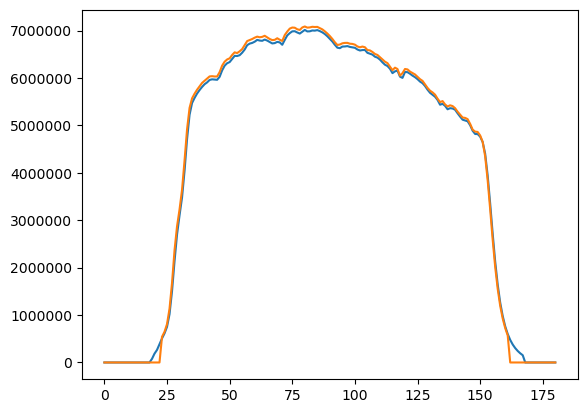

In [23]:
x1 = np.arange(len(orbit2_1Dspectra[0]))
x2 = np.arange(len(orbit2_1Dspectra[1]))
plt.plot(x1, orbit2_1Dspectra[0])
plt.plot(x2, orbit2_1Dspectra[1])
plt.show()

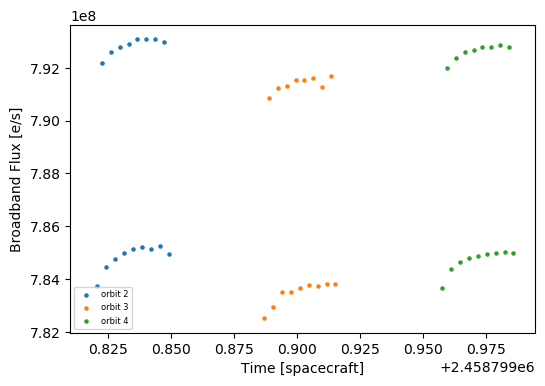

In [24]:

# x1 = np.arange(len(orbit1_broadbands))
# x2 = np.arange(len(orbit2_broadbands)) + x1[-1] + 1
# x3 = np.arange(len(orbit3_broadbands)) + x2[-1] + 1
# x4 = np.arange(len(orbit4_broadbands)) + x3[-1] + 1

fig, ax = plt.subplots(figsize=(6,4))
#plt.scatter(t1, y1, s=5, label='orbit 1')
plt.scatter(t2, y2, s=5, label='orbit 2')
plt.scatter(t3, y3, s=5, label='orbit 3')
plt.scatter(t4, y4, s=5, label='orbit 4')
plt.xlabel('Time [spacecraft]')
plt.ylabel('Broadband Flux [e/s]')
plt.legend(loc='best', fontsize=6)
plt.show()

In [25]:
meanflux1 = np.mean(y1)
meanerr1 = np.mean(e1)
meanflux2 = np.mean(y2)
meanerr2 = np.mean(e2)
meanflux3 = np.mean(y3)
meanerr3 = np.mean(e3)
meanflux4 = np.mean(y4)
meanerr4 = np.mean(e4)

print('Orbit 1')
print('Mean flux = %.1f'%(meanflux1))
print('Mean error = %.1f'%(meanerr1))
print('Relative error = %.3f percent'%(100.*meanerr1/meanflux1))
print('Orbit 2')
print('Mean flux = %.1f'%(meanflux2))
print('Mean error = %.1f'%(meanerr2))
print('Relative error = %.3f percent'%(100.*meanerr2/meanflux2))
print('Orbit 3')
print('Mean flux = %.1f'%(meanflux3))
print('Mean error = %.1f'%(meanerr3))
print('Relative error = %.3f percent'%(100.*meanerr3/meanflux3))
print('Orbit 4')
print('Mean flux = %.1f'%(meanflux4))
print('Mean error = %.1f'%(meanerr4))
print('Relative error = %.3f percent'%(100.*meanerr4/meanflux4))


Orbit 1
Mean flux = 787838429.3
Mean error = 28068.4
Relative error = 0.004 percent
Orbit 2
Mean flux = 788604328.4
Mean error = 28082.0
Relative error = 0.004 percent
Orbit 3
Mean flux = 787198093.9
Mean error = 28057.0
Relative error = 0.004 percent
Orbit 4
Mean flux = 788421695.4
Mean error = 28078.8
Relative error = 0.004 percent


## Normalizations